# Projet 7 : Implémentez un modèle de scoring


Construire un modèle de scoring qui donnera une prédiction sur la probabilité de non-solvabilité d'un client de façon automatique.

Dans un premier temps différent modèles de Machine learning sont tester pour sélectionner celui avec le meilleur potentiel de prédiction.

Ensuite, une fonction d'optimisation via la librairie "hyperopt" est définie. Elle a permis d'optimiser des paramètres suivant deux métriques différentes: la métrique technique de l4AUC et une métrique f_beta_score faite sur mesure pour notre problème. Les paramètres optimisés sont ceux du modèle ML ainsi que le seuil de solvabilité Les résultats ont été comparés et la métrique bancaire s'est avérée très pertinente.

Dans une dernière partie, le modèle final ainsi que la méthode Shap ont permis d'étudier quelles étaient les variables les plus influentes sur la  prédiction de la solvabilité d'un client, d'un point de vue global puis local i.e pour un client spécifique.

---

# Chargement des librairies et des données

In [1]:
#Chargement des libraries Python
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from numpy import isinf
import mlflow.sklearn
import mlflow
from zipfile import ZipFile
import time , pickle
import re

from imblearn.under_sampling import RandomUnderSampler

#Preprocessing, Upsampling, Model Selection, Model Evaluation
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.feature_selection import RFECV

import warnings
warnings.filterwarnings("ignore")
mlflow.autolog(silent=True)

In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':15,
     'ytick.labelsize':15,
     'axes.labelsize': 15,
     'legend.fontsize': 15,
     'axes.titlesize':15,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

In [3]:
#Importation des données dans l'environnement de travail
df = pd.read_csv("df_clean.csv",index_col=[0])
# Extrait les dimensions

# Nettoyage des données

## Supression des colones inutiles

In [4]:
#Supprie la colone index
df.drop("index", axis=1, inplace=True)

## Suppression des données manquantes dans 'TARGET'

In [5]:
#Suppression des indices ou il y a NA dans target
df.dropna(subset="TARGET", inplace=True)

## Suppression des donnérs avec plus de 10 % de données manquantes

In [6]:
#Remplace les données manquantes par la médian
df = df.fillna(df.median())

## Fixe un indices avec ID_clients et homogenétié des types

In [7]:
# Fix SK_ID_CURR comme index
df.set_index('SK_ID_CURR' ,inplace=True)
# S'assure que tout soitdes des float
df = df.astype(np.float64)

## Suppession de l'indice ou des valeur inf sont présente

In [8]:
#Localise les inf
index_to_drop = df.iloc[df.values==np.inf].index
#Drop les lignes contenant les inf
df.drop(index=index_to_drop, inplace=True)

In [375]:
df.shape

(307488, 543)

# Information Clients

Nous allons crée un tableau de donnée qui regroupe les information principales des clients qui sera ensuite utilisé par le dashboard.

In [9]:
#Information principale du client
info_client = df[["CODE_GENDER","DAYS_BIRTH","CNT_CHILDREN","AMT_INCOME_TOTAL","AMT_CREDIT","AMT_ANNUITY","AMT_GOODS_PRICE"]]
#Modification du code genre
info_client["CODE_GENDER"].replace(0,"Femme", inplace=True)
info_client["CODE_GENDER"].replace(1,"Homme", inplace=True)
#Calcul de l'âge
info_client["DAYS_BIRTH"] = round(info_client["DAYS_BIRTH"]/365)*-1

In [10]:
#État civil
etat_civil = df[['NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Separated', 'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Unknown','NAME_FAMILY_STATUS_Widow']]
#Convertie 0 et 1 an str
FAMILY_STATUS  = []
for i in range(0, etat_civil.shape[0]):
    etat = etat_civil.iloc[i]
    if etat['NAME_FAMILY_STATUS_Civil marriage'] == 1:
        FAMILY_STATUS.append("Marié(e)")
    elif etat['NAME_FAMILY_STATUS_Separated'] == 1:
        FAMILY_STATUS.append("Séparé(e)")
    elif etat['NAME_FAMILY_STATUS_Single / not married'] == 1:
        FAMILY_STATUS.append("Célibataire")
    elif etat['NAME_FAMILY_STATUS_Unknown'] == 1:
        FAMILY_STATUS.append("Inconnu(e)")
    elif etat['NAME_FAMILY_STATUS_Widow'] == 1:
        FAMILY_STATUS.append("Veuf(ve)")
    else:
        FAMILY_STATUS.append("Inconnu(e)")
#Ajout de la variable au donnée
info_client['FAMILY_STATUS'] = FAMILY_STATUS

In [11]:
#Crédit de clients
Credit = df[['NAME_CONTRACT_TYPE_Cash loans','NAME_CONTRACT_TYPE_Revolving loans']]
#Convertie 0 et 1 an str
NAME_CONTRACT_TYPE = [] 
for i in range(0, Credit.shape[0]):
    etat = Credit.iloc[i]
    if etat['NAME_CONTRACT_TYPE_Cash loans'] == 1:
        NAME_CONTRACT_TYPE.append("Prêt")
    elif etat['NAME_CONTRACT_TYPE_Revolving loans'] == 1:
        NAME_CONTRACT_TYPE.append("Crédit renouvelable")
    else:
        NAME_CONTRACT_TYPE.append("Aucun")
#Ajout de la variable au donné  
info_client['NAME_CONTRACT_TYPE'] = NAME_CONTRACT_TYPE

In [12]:
info_client

,CODE_GENDER,DAYS_BIRTH,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,FAMILY_STATUS,NAME_CONTRACT_TYPE
SK_ID_CURR,,,,,,,,,
100002,Femme,26.0,0.0,202500.0,406597.5,24700.5,351000.0,Célibataire,Prêt
100003,Homme,46.0,0.0,270000.0,1293502.5,35698.5,1129500.0,Inconnu(e),Prêt
100004,Femme,52.0,0.0,67500.0,135000.0,6750.0,135000.0,Célibataire,Crédit renouvelable
100006,Homme,52.0,0.0,135000.0,312682.5,29686.5,297000.0,Marié(e),Prêt
100007,Femme,55.0,0.0,121500.0,513000.0,21865.5,513000.0,Célibataire,Prêt
...,...,...,...,...,...,...,...,...,...
456251,Femme,26.0,0.0,157500.0,254700.0,27558.0,225000.0,Séparé(e),Prêt
456252,Homme,57.0,0.0,72000.0,269550.0,12001.5,225000.0,Veuf(ve),Prêt
456253,Homme,41.0,0.0,153000.0,677664.0,29979.0,585000.0,Séparé(e),Prêt


In [13]:
#Remet le SK_ID_CURR comme varaible
info_client.reset_index(inplace=True)
#Sauvegarde les données
info_client.to_csv("info_client.csv", index=True)

# Séparation du jeux des données en X, Y,  training et testing set

In [14]:
#Définition de X
X = df.drop("TARGET", axis=1)
#Extrait les dimensions
X.shape
#Renome les variables pour éviter de futur problème avec 
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [15]:
#Définition de Y
Y = df["TARGET"]
#Extrait les dimensions
Y.shape

(307488,)

In [16]:
#Division du jeux de données en trainning testing set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [17]:
# Extrait les dimension des différent tableau
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((245990, 542), (61498, 542), (245990,), (61498,))

# Baseline model - Logistic Regression

Le projet consiste à comprendre les défaut de paiment de crédit de certain client et de pouvoir potentiellment l'estimer. La prédiction se résume par une sortie binaire, une acceptation ou un refus de crédit. Pour avoir une première idée de se potentiel nous allons commencer par une régression logistique.

In [18]:
from sklearn.linear_model import LogisticRegression

In [315]:
#Création des graph résumant les différentes métrique d'évalaution du modèle
def model_summary(model, y_true, y_pred, y_pred_proba, feature_importances):
    #Initation de la figure et définition de la taille de la figure
    fig = plt.figure(figsize=(20,15))
    #Emplacement du premier graph
    plt.subplot(221)
    #Création d'un matrice de confusion
    cf_matrix = confusion_matrix(y_true, y_pred)
    #Nom des cases de la matrice de confusion
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    #Comptage du nombre de prédiction effecuté dans chacune des cases
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    #Nombre de ces prédiction en pourcentage
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    #Création des labels avec les nom et valeurs calculer au dessus  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    #Change le format du label 
    labels = np.asarray(labels).reshape(2,2)
    #Création du Heatmap de la matrice de confusion
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    #Emplacement de la second graph
    plt.subplot(222)
    #Calcule de la courbe ROC
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    #Création du graph avec la courbe ROC
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    #Ajout de la bissectrive
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    #Label de x
    plt.xlabel('False Positive Rate')
    #Label de y
    plt.ylabel('True Positive Rate')
    #Ajout de la légende
    plt.legend()
    # Si l'argument  feature_importances = True alors:
    if feature_importances: 
        #Emplacement du troisieme graph
        plt.subplot(212)
        #Extratit les indidces des features importance dans l'ordre en partant de la fin
        indices = np.argsort(model.feature_importances_)[::-1]
        #Création d'une liste vide pour enregistrer les features
        features = []
        # Pour i dans 0 à 19
        for i in range(20):
           #Après sélection RFECV  X_test_selected est créé
            features.append(X_test_selected.columns[indices[i]]) 
        #Création du barplaot avec les feature_importance
        sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))            
        #Labels de x
        plt.xlabel('Features importance')
        #Rotation des labels
        plt.xticks(rotation=90)
        #Visualtion de la figure
    plt.show()

AUC : 0.5727
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56558
         1.0       0.10      0.00      0.00      4940

    accuracy                           0.92     61498
   macro avg       0.51      0.50      0.48     61498
weighted avg       0.85      0.92      0.88     61498



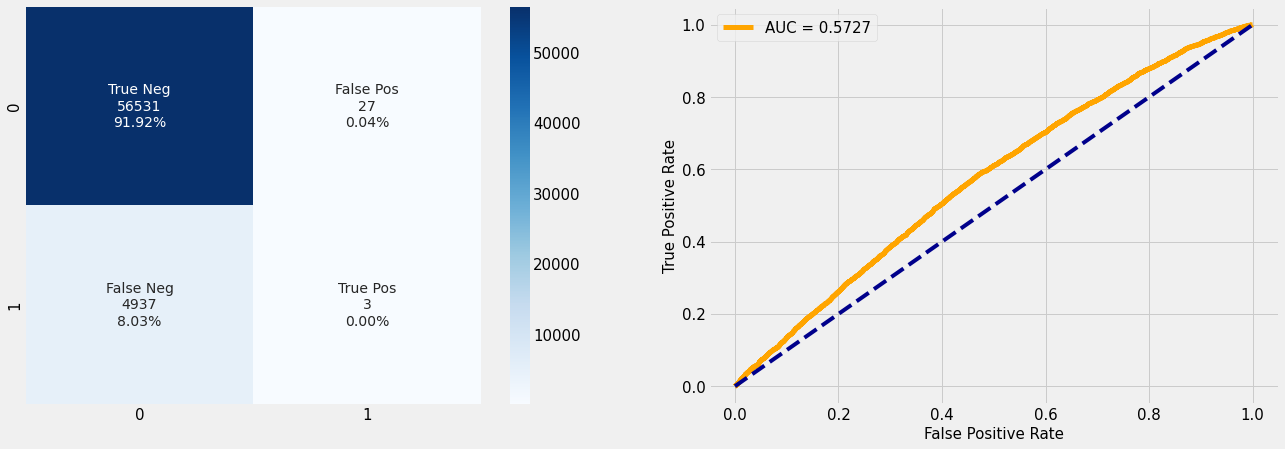

In [316]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))
model_summary(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], feature_importances=None)

Nous observons un fort déséquilibre entre la précision trouvée pour les clients solvable (TARGET = 0) (True Neg : 91.92%) et les clients non- solvable (TARGET = 1) (True Pos : 0%). Ceci est dû au déséquilibre de la variables target dont 92% des individus sont classés solvable et 8% non-solvable, à savoir en défaut de paiement de crédit.

Il est donc intéressant de travailler ce problème de suréchantillonnage en ajustant la distribution de classe (solvable, non-solvable) de manière à avoir une répartition plus homogène.

# Rééquilibrage des données

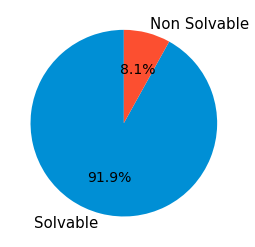

In [21]:
# Crée les valeurs à représenté
target_values = Y.value_counts()/df.shape[0]*100
# create a figure and set different background
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie(target_values, autopct='%1.1f%%',labels=["Solvable", "Non Solvable"], startangle=90)
plt.show()

Les données 'TARGET' que nous devons prédire au départ ne sont pas équilibrer comme le montre le graph ci-dessus.

In [22]:
%%time
#Initie l'algorimt RandomUnderSampler
rus = RandomUnderSampler()
#Fit le modèle
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

CPU times: total: 828 ms
Wall time: 1.12 s


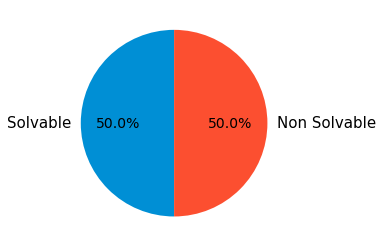

In [23]:
# Crée les valeurs à représenté
target_values = y_train_rus.value_counts()/y_train_rus.shape[0]*100
# create a figure and set different background
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie(target_values, autopct='%1.1f%%',labels=["Solvable", "Non Solvable"], startangle=90)
plt.show()

Les donnés à prédire sont maintenant réquilibrer, nous allons relancer voir si il y un amélioration.

AUC : 0.6090
              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86     56558
         1.0       0.12      0.31      0.17      4940

    accuracy                           0.76     61498
   macro avg       0.52      0.55      0.52     61498
weighted avg       0.86      0.76      0.81     61498



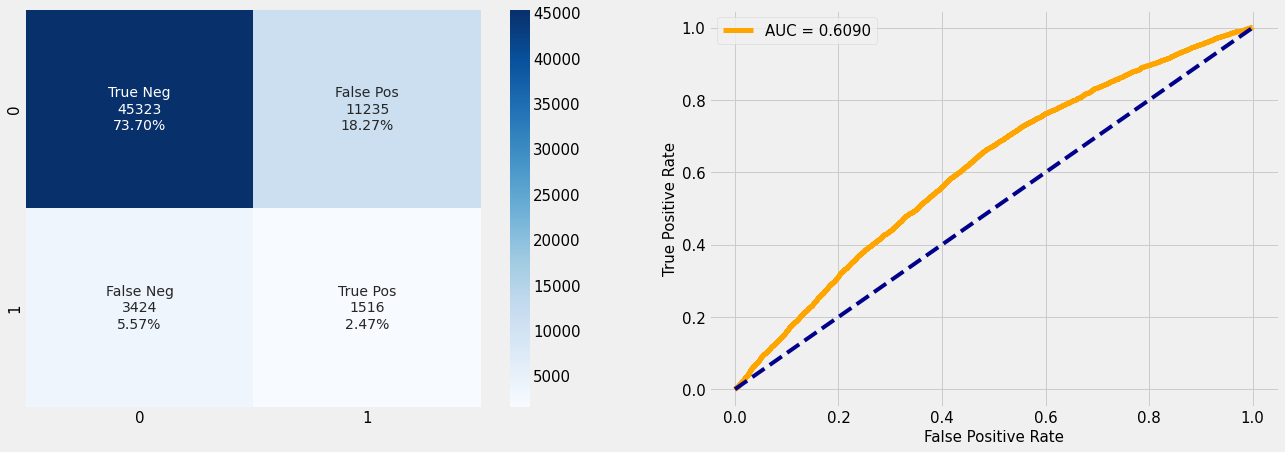

CPU times: total: 4.23 s
Wall time: 8.89 s


In [320]:
%%time
lr = LogisticRegression()
lr.fit(X_train_rus, y_train_rus)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))
model_summary(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], feature_importances=None)

Nous avons amélioration de l'AUC score de 0.03 que nous maintenant tentre d'améliorer en tester d'autre algorithme de classification.

# Sélection modèle

In [25]:
#Predictive Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier

classifiers = [DummyClassifier(),
               RandomForestClassifier(),
               MLPClassifier(),
               KNeighborsClassifier(),
               LGBMClassifier()
              ]


La fonction suivante *train_models* peut calculer les métriques auc, accuracy, f1, precision et recall.

In [26]:
def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': f1_score(y_test, model.predict(X_test))
      }
          
    return output

In [27]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in classifiers:
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
base_models.sort_values('AUC', ascending=False, inplace=True)

CPU times: total: 9h 18min 44s
Wall time: 4h 23min 30s


In [28]:
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Time
4,LGBMClassifier,0.773923,0.920046,0.533141,0.037449,0.069983,50.398234
1,RandomForestClassifier,0.709364,0.919688,0.555556,0.001012,0.002021,477.787109
3,KNeighborsClassifier,0.541787,0.91429,0.167002,0.016802,0.030532,14414.77619
0,DummyClassifier,0.5,0.919672,0.0,0.0,0.0,5.843815
2,MLPClassifier,0.499925,0.91964,0.0,0.0,0.0,861.491666


Nous allons comparer une nouvelle fois nos modèles, cette fois-ci l'entrainement se fera avec les données RandomUndersampling.

In [29]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in classifiers:
    start = time.time()
    results = train_models(model, X_train_rus, X_test, y_train_rus, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
models_res = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T        
models_res.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_res.sort_values('AUC', ascending=False, inplace=True)

CPU times: total: 30min 2s
Wall time: 15min 34s


In [30]:
models_res

,Model,AUC,Accuracy,Precision,Recall,F1,Time
4,LGBMClassifier,0.76935,0.700885,0.169492,0.698381,0.272781,22.767863
1,RandomForestClassifier,0.737786,0.68864,0.157639,0.662146,0.254652,77.694901
3,KNeighborsClassifier,0.564821,0.54553,0.095354,0.548785,0.162476,704.481165
2,MLPClassifier,0.550889,0.473202,0.094132,0.644534,0.164272,123.478015
0,DummyClassifier,0.5,0.919672,0.0,0.0,0.0,6.265151


LGBMClassifier reste le "plus performant" en terme de temps d'éxécution des calcules et du score AUC. 

# **Feature Selection - Recursive Feature Elimination**

Maintenant que nous avons testé ces 5 algorithm de classification, on peut effectuer lla sélection des features avec LGBMClassifier qui permet d'obtenir les meilleurs performances AUC score / Time. Jusqu'ici nous conserver tout la quasi totalité des features 542 features, mais beaucoup peuvent surement être supprimer.

La fontion RFECV de Scikit-learn permet de maximiser les performance du modèles en recherchant un ensemble de features optimal avec l'application d'une validation croisé. Le but est d'améliorer le AUC en conservant le moins de features possible mais les plus importantes. 

Étant donnée que nous avons un modèle plus performant avec les données rééquilibrer, nous allons effectuer la sélectionner des features sur celle-ci.  

In [31]:
%%time
start = time.time()
rfecv = RFECV(estimator=LGBMClassifier(objective='binary'), 
              step=5, 
              cv=StratifiedKFold(5), 
              scoring='roc_auc', 
              verbose=2,
              n_jobs=-1)
rfecv.fit(X_train_rus, y_train_rus)

print('Time Elapsed: {}'.format(time.time()-start))

Fitting estimator with 542 features.
Fitting estimator with 537 features.
Fitting estimator with 532 features.
Fitting estimator with 527 features.
Fitting estimator with 522 features.
Fitting estimator with 517 features.
Fitting estimator with 512 features.
Fitting estimator with 507 features.
Fitting estimator with 502 features.
Fitting estimator with 497 features.
Fitting estimator with 492 features.
Fitting estimator with 487 features.
Fitting estimator with 482 features.
Fitting estimator with 477 features.
Fitting estimator with 472 features.
Fitting estimator with 467 features.
Fitting estimator with 462 features.
Fitting estimator with 457 features.
Fitting estimator with 452 features.
Fitting estimator with 447 features.
Fitting estimator with 442 features.
Fitting estimator with 437 features.
Fitting estimator with 432 features.
Fitting estimator with 427 features.
Fitting estimator with 422 features.
Fitting estimator with 417 features.
Fitting estimator with 412 features.
F

In [32]:
print("Le nombre optimal de features : %d" % rfecv.n_features_)
print("Selected Features: %s" % rfecv.support_[:20])
print("Feature Ranking : %s" % rfecv.ranking_[:20])

Le nombre optimal de features : 182
Selected Features: [ True  True False False  True  True  True  True  True  True  True  True
  True False False False False  True False False]
Feature Ranking : [ 1  1 13 15  1  1  1  1  1  1  1  1  1 26 29 17 25  1 29 29]


RFECV ne sélectionne que les features qui ont obtenue un Rank de 1. Ci-dessous la sélection des features avec cross-validation.

In [33]:
ranking = pd.DataFrame({'Features': X.columns})
ranking['RANK'] = np.asarray(rfecv.ranking_)
ranking.sort_values('RANK', inplace=True)

features_selection = ranking[ranking.RANK == 1]['Features'].to_list()
print(len(features_selection))
print(features_selection)

182
['CODE_GENDER', 'PREV_AMT_APPLICATION_MEAN', 'PREV_AMT_APPLICATION_MAX', 'PREV_AMT_ANNUITY_MEAN', 'PREV_AMT_ANNUITY_MAX', 'PREV_AMT_ANNUITY_MIN', 'CLOSED_MONTHS_BALANCE_SIZE_SUM', 'PREV_AMT_CREDIT_MAX', 'CLOSED_AMT_CREDIT_SUM_DEBT_MEAN', 'CLOSED_AMT_CREDIT_SUM_MEAN', 'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'CLOSED_DAYS_CREDIT_UPDATE_MEAN', 'CLOSED_DAYS_CREDIT_ENDDATE_MEAN', 'CLOSED_DAYS_CREDIT_ENDDATE_MAX', 'CLOSED_DAYS_CREDIT_MEAN', 'CLOSED_AMT_CREDIT_SUM_SUM', 'PREV_AMT_CREDIT_MEAN', 'PREV_APP_CREDIT_PERC_MIN', 'PREV_APP_CREDIT_PERC_MAX', 'PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY_MEAN', 'PREV_CNT_PAYMENT_SUM', 'PREV_CNT_PAYMENT_MEAN', 'PREV_DAYS_DECISION_MEAN', 'PREV_DAYS_DECISION_MAX', 'PREV_DAYS_DECISION_MIN', 'PREV_RATE_DOWN_PAYMENT_MEAN', 'PREV_HOUR_APPR_PROCESS_START_MEAN', 'PREV_AMT_GOODS_PRICE_MIN', 'PREV_AMT_DOWN_PAYMENT_MEAN', 'PREV_AMT_DOWN_PAYMENT_MAX', 'PREV_APP_CREDIT_PERC_VAR'

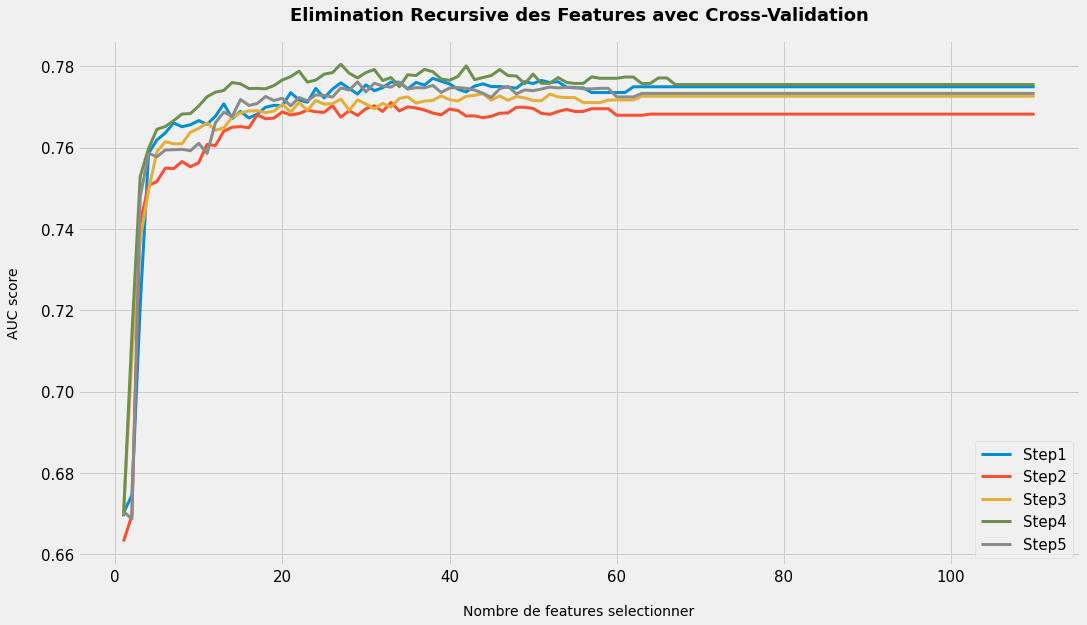

In [34]:
##Plot la sélection des features en fonction du score de l'AUC
plt.figure(figsize=(16, 9))
plt.title('Elimination Recursive des Features avec Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Nombre de features selectionner', fontsize=14, labelpad=20)
plt.ylabel('AUC score', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, linewidth=3)
plt.legend(['Step1','Step2','Step3','Step4','Step5'])
plt.show()

 Comme nous montre le graph ci-dessus, le RFECV nous permet de visualiser l'importance du nombre des features sélectionnées en fonction du score l'AUC obtenue pour chaque ajout de features.

In [35]:
#Creation d'un nouveau tableau de X avec les features sélectionner
data_trim = X.loc[:, X.columns[rfecv.get_support()]]
data_trim.shape

(307488, 182)

# **Sauvegarde des données avec les features sélectionner**

Il est nécessaire de sauvegarder le dataset data_trim de manière à pouvoir le réutiliser facilement…

In [36]:
### Merge avec TARGET pour regrouper toutes les features nécessaire à al suite de l'étude ensemble
data_trim = data_trim.merge(Y, left_index=True, right_index=True)
data_trim.reset_index(inplace=True)

In [37]:
#Enregistre les données csv dans un zip. 
compression_opts = dict(method='zip', archive_name='data_trim.zip')
data_trim.to_csv('data_trim.csv', index=False, compression=compression_opts)

Nous allons sauvegarder deux jeux de données, le premier ci-dessus stocke la totalité des individus en rapport avec les 132 best features identifiées. Le second sera un échantillon permettant, si besoin, d'effectuer des tests plus rapidement, par exemple si l'utilité est nécessaire pour la conception de l'application.

In [38]:
#Enregistre un échatillons des données csv
data_trim_sample = data_trim.sample(10000)
data_trim_sample.to_csv('data_trim_sample.csv', index=False)

# Analyse de data drift

In [39]:
#from sklearn import datasets
#from evidently.test_suite import TestSuite
#from evidently.test_preset import DataStabilityTestPreset
#from evidently.test_preset import DataQualityTestPreset
#from evidently.report import Report
#from evidently.metric_preset import DataDriftPreset

#data_drift_report = Report(metrics=[DataDriftPreset(),])
#Replace reference by data by all and current by samples
#data_drift_report.run(current_data=data_trim, reference_data=data_trim_sample, column_mapping=None)
#data_drift_report.save_html("data_drift_report.html")

# Test de la sélection des features sur l'ensemble des algorithm

In [145]:
#Transform data with rfecv 
X_train_selected = X_train[features_selection]
X_test_selected = X_test[features_selection]
X_train_rus_selected = X_train_rus[features_selection]

In [146]:
#Redéfnie les algrithm choisie
classifiers = [DummyClassifier(),
               RandomForestClassifier(),
               MLPClassifier(),
               KNeighborsClassifier(),
               LGBMClassifier()
              ]


In [147]:
def train_models(model, X_train_selected, X_test_selected, y_train, y_test):
    model.fit(X_train_selected, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test_selected)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test_selected)),
      'Precision': precision_score(y_test, model.predict(X_test_selected)),
      'Recall': recall_score(y_test, model.predict(X_test_selected)),
      'F1': f1_score(y_test, model.predict(X_test_selected))
      }
          
    return output

In [148]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in classifiers:
    start = time.time()
    results = train_models(model, X_train_selected, X_test_selected, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
models_rfe = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
models_rfe.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_rfe.sort_values('AUC', ascending=False, inplace=True)

CPU times: total: 4h 14min 46s
Wall time: 2h 35min 38s


In [149]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in classifiers:
    start = time.time()
    results = train_models(model, X_train_rus_selected, X_test_selected, y_train_rus, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
models_rus_rfe = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
models_rus_rfe.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_rus_rfe.sort_values('AUC', ascending=False, inplace=True)

CPU times: total: 14min 36s
Wall time: 8min 39s


In [150]:
#Models performance with features selection
models_rfe

,Model,AUC,Accuracy,Precision,Recall,F1,Time
4,LGBMClassifier,0.7733,0.919949,0.526814,0.033806,0.063534,17.620532
1,RandomForestClassifier,0.716634,0.919591,0.352941,0.001215,0.002421,392.279086
3,KNeighborsClassifier,0.548578,0.914355,0.146868,0.013765,0.025171,8652.537493
2,MLPClassifier,0.500147,0.91964,0.0,0.0,0.0,269.936616
0,DummyClassifier,0.5,0.919672,0.0,0.0,0.0,6.290345


In [151]:
#Models performance with features selection
models_rus_rfe

,Model,AUC,Accuracy,Precision,Recall,F1,Time
4,LGBMClassifier,0.771637,0.699519,0.169313,0.701619,0.272795,11.783595
1,RandomForestClassifier,0.744203,0.691193,0.160128,0.67004,0.258483,55.143201
3,KNeighborsClassifier,0.578498,0.563921,0.099715,0.551619,0.168898,408.04872
2,MLPClassifier,0.556565,0.877134,0.164787,0.130162,0.145442,39.558881
0,DummyClassifier,0.5,0.919672,0.0,0.0,0.0,4.545697


In [152]:
###Reminder before… features selection
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Time
4,LGBMClassifier,0.773923,0.920046,0.533141,0.037449,0.069983,50.398234
1,RandomForestClassifier,0.709364,0.919688,0.555556,0.001012,0.002021,477.787109
3,KNeighborsClassifier,0.541787,0.91429,0.167002,0.016802,0.030532,14414.77619
0,DummyClassifier,0.5,0.919672,0.0,0.0,0.0,5.843815
2,MLPClassifier,0.499925,0.91964,0.0,0.0,0.0,861.491666


On constate que le LGBMClassifier est le meilleur modèle avec un score AUC élévé et un temps d'éxécution relativement faible. Pour une AUC équivalent le RandomForestClassifier est beaucoup plus long en terme de temps de calcul. Le KNeighborsClassifier est le plus long à calculer avec une AUC moindre. Le DummyClassifier est le plus rapide mais obtient le AUC score le plus faible. 

----


# Définition de la fonction côut

Dans notre cas d'étude, nous avons affaire à une une classification binaire 0 ou 1, solvable ou non, négatif ou positif.

![tableau](tableau.png)

Comme nous le montre le tabeau ci-dessus il exisite quatre cas de figure pour concernant les prédiction du modèle:

1. Les clients qui sont solvables, donc 0 , et dont la prédiction est de 0 sont les 'True Negatives' (TN).
2. Les clients qui sont solvables, donc 0, et dont la prédiction est de 1, c'est à dire non-solvable, sont les 'False Positives' (FP).
3. Les clients qui ne sont pas solvable, donc 1, et dont la prédiction est de 0, donc solvable sont les 'False Negatives' (FN).
4. Les clients qui ne sont pas solvable, donc 1, et dont la prédiction est de 1 sont les 'True Positives' (TP).

Dans nos données, il y a une fortes disparité entre les clients solvable (TARGET = 0) et non solvable (TARGET = 1), ce qui peut expliquer ce fort taux de faux positifs (False Positive Rate). Ce fort taux de faux positifs peux engendrer un perte de clients potentiels car le crédit client serait refusé à tort, alors qu'il aurait été en mesure de le remboursé. A l'inverse, nous cherchons également à limiter le nombre faux negatifs car si le crédit est accordé à un client qui n'est pas capable de rembourser, c'est un perte nette pour la banque.

Ainsi, les pertes engendrer par un crédit en raison d'une mauvaise classification dépendront des probabilités Faux Positifs et Faux Négatifs. Afin d'éviter les perte d'opportunité ou financière, nous allons pénalier les FP et les FN ce qui implique de maximiser deux critères, le Recall et la Precision.

La précision permet de connaître le nombre de prédictions positifs bien effectuées:

$$Precision=\frac{TP}{TP+FP}$$

Le recall permet de savoir le pourcentage de positifs bien prédit par notre modèle:

$$Recall=\frac {TP}{TP+FN}$$

Mais séparément, c’est deux métrique sont inutiles :
- si le modèle prédit tout le temps « positif », le recall sera élevé
- au contraire, si le modèle ne prédit jamais « positif », la precision sera élevée

Pour contre carré cela, l' évaluation de la performance de notre modèle se fera avec le  F<sub>1</sub> Score:

$$ F_{1}~score= 2 \times \frac {precision \times recall}{precision + recall}$$

Le F<sub>1</sub> score est ce qu’on appelle la moyenne harmonique, plus il est élevé, plus le modèle est performant. Mais le F<sub>1</sub> score à tendance à favoriser la précision sur le recall. Pour remedier nous allons le F<sub>$\beta$</sub>

$$F_{\beta}~score= \frac {(1+\beta^2)\times (precision \times recall)}{\beta^2 \times precision + recall}$$

Le calcul de ce score nécessite de définir \beta, qui répresente l'importance relative que l'on souhaite à la précision ou au recall. Plus $\beta$ est élevé, plus accorde de l'importance au recall et plus $\beta$ est proche de 0, plus on accorde de l'importance à la précision. Celà revient à estimer la différence de perte financière engendrer par le refus d'un prêt à un client solvable (FP, présicion) avec celle generé par l'accord d'un prêt à un client non-solvable (FN, recall). 

Maximiser le recall, $\beta$ élevé, revient à minimiser les FN. Alors que maximiser la précision, $\beta$ proche de zéro, revient à miniser les FP.

Ici nous allons emmètre l'hypothèse que les pertes financière générer par l'accord d'un prêt à un clients qui n'est pas solvable sont plus elevé que celle perte créé par un refus de prêt à un client solvable. Nous voulons donc minimiser les FN en accordant plus d'importance au recall et donc fixer un  $\beta = 4$. 

Maintenant nous allons teste afin de vérifier que le F<sub>$\beta$</sub>  que les FP et en particulier les FN soit bien prénaliser.

In [431]:
#Tests fonctionels avec des listes contenant tp, tn, fp, fn
test_0 = [500, 300, 10, 30]
test_1 = [500, 300, 30, 10]
test_2 = [400, 300, 70, 50]
test_3 = [400, 300, 50, 70]
test_4 = [350, 250, 120, 80]
test_5 = [350, 250, 80, 120]
# Liste des test
tests = [test_0, test_1, test_2, test_3, test_4, test_5]
#Boucles de calcule des différents score
for i, t in enumerate(tests):
    tp = t[0]
    tn = t[1]
    fn = t[2]
    fp = t[3]
    print("############################")
    print("Test", i, ": TP =",tp,",TN =",tn,",FP =",fp,",FN =",fn)
    beta = 4
    recall = tp / (tp + fn)
    print("Recall :", round(recall,3))
    precision = tp / (tp + fp)
    print("Precision :",round(precision,3))
    fscore =((1 + beta**2) * precision * recall) / ((beta**2 * precision) + recall)
    print("Score :" ,round((fscore),3))


############################
Test 0 : TP = 500 ,TN = 300 ,FP = 30 ,FN = 10
Recall : 0.98
Precision : 0.943
Score : 0.978
############################
Test 1 : TP = 500 ,TN = 300 ,FP = 10 ,FN = 30
Recall : 0.943
Precision : 0.98
Score : 0.945
############################
Test 2 : TP = 400 ,TN = 300 ,FP = 50 ,FN = 70
Recall : 0.851
Precision : 0.889
Score : 0.853
############################
Test 3 : TP = 400 ,TN = 300 ,FP = 70 ,FN = 50
Recall : 0.889
Precision : 0.851
Score : 0.887
############################
Test 4 : TP = 350 ,TN = 250 ,FP = 80 ,FN = 120
Recall : 0.745
Precision : 0.814
Score : 0.748
############################
Test 5 : TP = 350 ,TN = 250 ,FP = 120 ,FN = 80
Recall : 0.814
Precision : 0.745
Score : 0.81


Nous observons une augmentation du score lorque la solvabilité des clients est bien prédites. Et inversement diminue nous montre bien qu'il y a une des risque de pertes financière avec l' élévation du nombre de FP et FN. Nous maintenant crée la fonction F_beta_score pour l'utiliser par la suite dans l'évaluation de nos modèles.

In [430]:
def F_beta_score(y_true, y_pred, beta=4) :
    
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred).ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    fscore =((1 + beta**2) * precision * recall) / ((beta**2 * precision) + recall)

    return fscore

In [366]:
def cost_false(model, y_true, X_true):
    '''Cost function analyzes prediction errors False Pos. and False Neg.'''
    cm = confusion_matrix(y_true, model.predict(X_true))
    FP = cm[0][1]/np.sum(cm)
    FN = cm[1][0]/np.sum(cm)
  
    print("False Pos: {0:.2%}".format(FP))
    print("False Neg: {0:.2%}".format(FN))
    return FP, FN

# Hyperparameters tunning - Hyperopt et AUC score

Maitenant nous afinner les hyperparamètres de algorithme d’apprentissage automatique afin d'en optimiser ses performances. nous allons comparer nos deux méthodes d'évaulaiton d'apprentissage avec l'AUC score.

In [157]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
import mlflow.sklearn
import mlflow
from mlflow import MlflowClient
import time

In [158]:
# Définitions des valeurs des hyperparamètre à tester
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
    }

Nous allons crée une fonction qui va nous permettre de comparer la performances des modèles LGBMClassifier issue d'un entrenaiment sur les données équilibrer et déséqulibrer, mais également avec différent score d'évaluation l'AUC et  le F_beta_score définie précédément.

## Optimisation des hyperparamètre des modèles

In [159]:
#CréAtion de la fonction d'optimisation des hyperparamètre en fonction du score d'évaluation d'apprentissage
def objective(params):
    #Définition des paramètre
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        'device':'gpu'
        }
    #Modèle à optimiser avec les paramètres (params) et leur valeur respective définie par space
    model= LGBMClassifier(**params)
    #Fixed le Cross validation à 5
    cv = StratifiedKFold(5)
    #Prédicion de y
    y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)
    #Évaluation par le score F_beta_score
    score = F_beta_score(y_train, y_pred)
    #Inverse le score afin de l'optimiser en le minisant
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [160]:
%%time
## Donnée déséquilibrer et F_beta_score.
best_des_fbeta = fmin(fn=objective, space=space, max_evals=30, rstate=np.random.default_rng(1), algo=tpe.suggest)

100%|██████████| 30/30 [45:45<00:00, 91.51s/trial, best loss: 0.005146100812122745] 
CPU times: total: 2h 21min 20s
Wall time: 45min 45s


In [161]:
#CréAtion de la fonction d'optimisation des hyperparamètre en fonction du score d'évaluation d'apprentissage
def objective(params):
    #Définition des paramètre
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        'device':'gpu'
        }
    #Modèle à optimiser avec les paramètres (params) et leur valeur respective définie par space
    model= LGBMClassifier(**params)
    #Fixed le Cross validation à 5
    cv = StratifiedKFold(5)
    #Prédicion de y
    y_pred = cross_val_predict(model, X_train_rus_selected, y_train_rus, method='predict', cv=cv)
    #Évaluation par le score F_beta_score
    score = F_beta_score(y_train_rus, y_pred)
    #Inverse le score afin de l'optimiser en le minisant
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [162]:
%%time
## Donnée rééquilibrer et F_beta_score.
best_eq_fbeta = fmin(fn=objective, space=space, max_evals=30, rstate=np.random.default_rng(1), algo=tpe.suggest)

100%|██████████| 30/30 [28:08<00:00, 56.28s/trial, best loss: 0.4654233229909951] 
CPU times: total: 58min 37s
Wall time: 28min 8s


In [163]:
#CréAtion de la fonction d'optimisation des hyperparamètre en fonction du score d'évaluation d'apprentissage
def objective(params):
    #Définition des paramètre
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        'device':'gpu'
        }
    #Modèle à optimiser avec les paramètres (params) et leur valeur respective définie par space
    model= LGBMClassifier(**params)
    #Fixed le Cross validation à 5
    cv = StratifiedKFold(5)
    #Évaluation par le score roc_auc
    score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()
    #Inverse le score afin de l'optimiser en le minisant
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [164]:
%%time
## Donnée déséquilibrer et roc_auc.
best_des_auc = fmin(fn=objective, space=space, max_evals=30, rstate=np.random.default_rng(1), algo=tpe.suggest)

100%|██████████| 30/30 [51:42<00:00, 103.42s/trial, best loss: 0.2184530329529124] 
CPU times: total: 3h 3min 34s
Wall time: 51min 42s


In [165]:
#CréAtion de la fonction d'optimisation des hyperparamètre en fonction du score d'évaluation d'apprentissage
def objective(params):
    #Définition des paramètre
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        'device':'gpu'
        }
    #Modèle à optimiser avec les paramètres (params) et leur valeur respective définie par space
    model= LGBMClassifier(**params)
    #Fixed le Cross validation à 5
    cv = StratifiedKFold(5)
    #Évaluation par le score roc_auc
    score = cross_val_score(model, X_train_rus_selected, y_train_rus, scoring='roc_auc', cv=cv).mean()
    #Inverse le score afin de l'optimiser en le minisant
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [166]:
%%time
## Donnée réséquilibrer et roc_auc.
best_eq_auc = fmin(fn=objective, space=space, max_evals=30, rstate=np.random.default_rng(1), algo=tpe.suggest)

100%|██████████| 30/30 [32:35<00:00, 65.19s/trial, best loss: 0.22035806402658653]
CPU times: total: 1h 26min 42s
Wall time: 32min 35s


Maintenant que les hyperparamètre on été optimiser pour les 4 modéles, nous quantifer leur différences.

## Fonction commune

In [167]:
def train_models_v2(model, X_train_selected, X_test_selected, y_train, y_test):
    model.fit(X_train_selected, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test_selected)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test_selected)),
      'Precision': precision_score(y_test, model.predict(X_test_selected)),
      'Recall': recall_score(y_test, model.predict(X_test_selected)),
      'F1': f1_score(y_test, model.predict(X_test_selected)),
      'F_beta': F_beta_score(y_test, model.predict(X_test_selected), beta=4)
        
      }
          
    return output

## Définition des modèles avec les paramètre optimiser

In [168]:

#Création d'un dictionnaire de modèle les algorithm choisie
classifiers = {"lgbm_des_fbeta": LGBMClassifier( #Modèle lgbm entrainer avec des donnée équilibrer et apprentissage au F_beta_score.
                    n_estimators=int(best_des_fbeta['n_estimators']), 
                    colsample_bytree= best_des_fbeta['colsample_bytree'],
                    learning_rate= best_des_fbeta['learning_rate'],
                    max_depth= int(best_des_fbeta['max_depth']),
                    subsample= best_des_fbeta['subsample'],
                    reg_lambda= best_des_fbeta['reg_lambda'],
                    device='gpu'),
               
               "lgbm_eq_fbeta": LGBMClassifier(#Modèle lgbm entrainer avec des donnée équilibrer et apprentissage au F_beta_score.
                   n_estimators=int(best_eq_fbeta['n_estimators']), 
                   colsample_bytree= best_eq_fbeta['colsample_bytree'],
                   learning_rate= best_eq_fbeta['learning_rate'],
                   max_depth= int(best_eq_fbeta['max_depth']),
                   subsample= best_eq_fbeta['subsample'],
                   reg_lambda= best_eq_fbeta['reg_lambda'],
                   device='gpu'),
               
               "lgbm_des_auc": LGBMClassifier(#Modèle lgbm entrainer avec des donnée déséquilibrer et apprentissage au auc score
                   n_estimators=int(best_des_auc['n_estimators']), 
                   colsample_bytree= best_des_auc['colsample_bytree'],
                   learning_rate= best_des_auc['learning_rate'],
                   max_depth= int(best_des_auc['max_depth']),
                   subsample= best_des_auc['subsample'],
                   reg_lambda= best_des_auc['reg_lambda'],
                   device='gpu'),
               
               "lgbm_eq_auc" : LGBMClassifier(#Modèle lgbm entrainer avec des donnée équilibrer et apprentissage au auc score.
                   n_estimators=int(best_eq_auc['n_estimators']),
                   colsample_bytree= best_eq_auc['colsample_bytree'],
                   learning_rate= best_eq_auc['learning_rate'],
                   max_depth= int(best_eq_auc['max_depth']),
                   subsample= best_eq_auc['subsample'],
                   reg_lambda= best_eq_auc['reg_lambda'],
                   device='gpu')
              }


# Évalutation des modèles sur les donnée déséquilibrer

In [376]:
%%time

names = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
f_beta =[]
time_ = []

for name, model in classifiers.items():
    start = time.time()
    results = train_models_v2(model, X_train_selected, X_test_selected, y_train, y_test)
   
    names.append(name)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    f_beta.append(results['F_beta'])
    time_.append(time.time()-start)

#Initialise data of lists
models_final_des = pd.DataFrame(data=[names, auc, accuracy, precision, recall, f1, f_beta, time_]).T
models_final_des.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1','F_beta', 'Time']
models_final_des.sort_values('F_beta', ascending=False, inplace=True)

CPU times: total: 7min 4s
Wall time: 1min 48s


## lgbm_des_fbeta

In [377]:
lgbm_des_fbeta = classifiers["lgbm_des_fbeta"]

In [378]:
roc_auc = roc_auc_score(y_test, lgbm_des_fbeta.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.713276


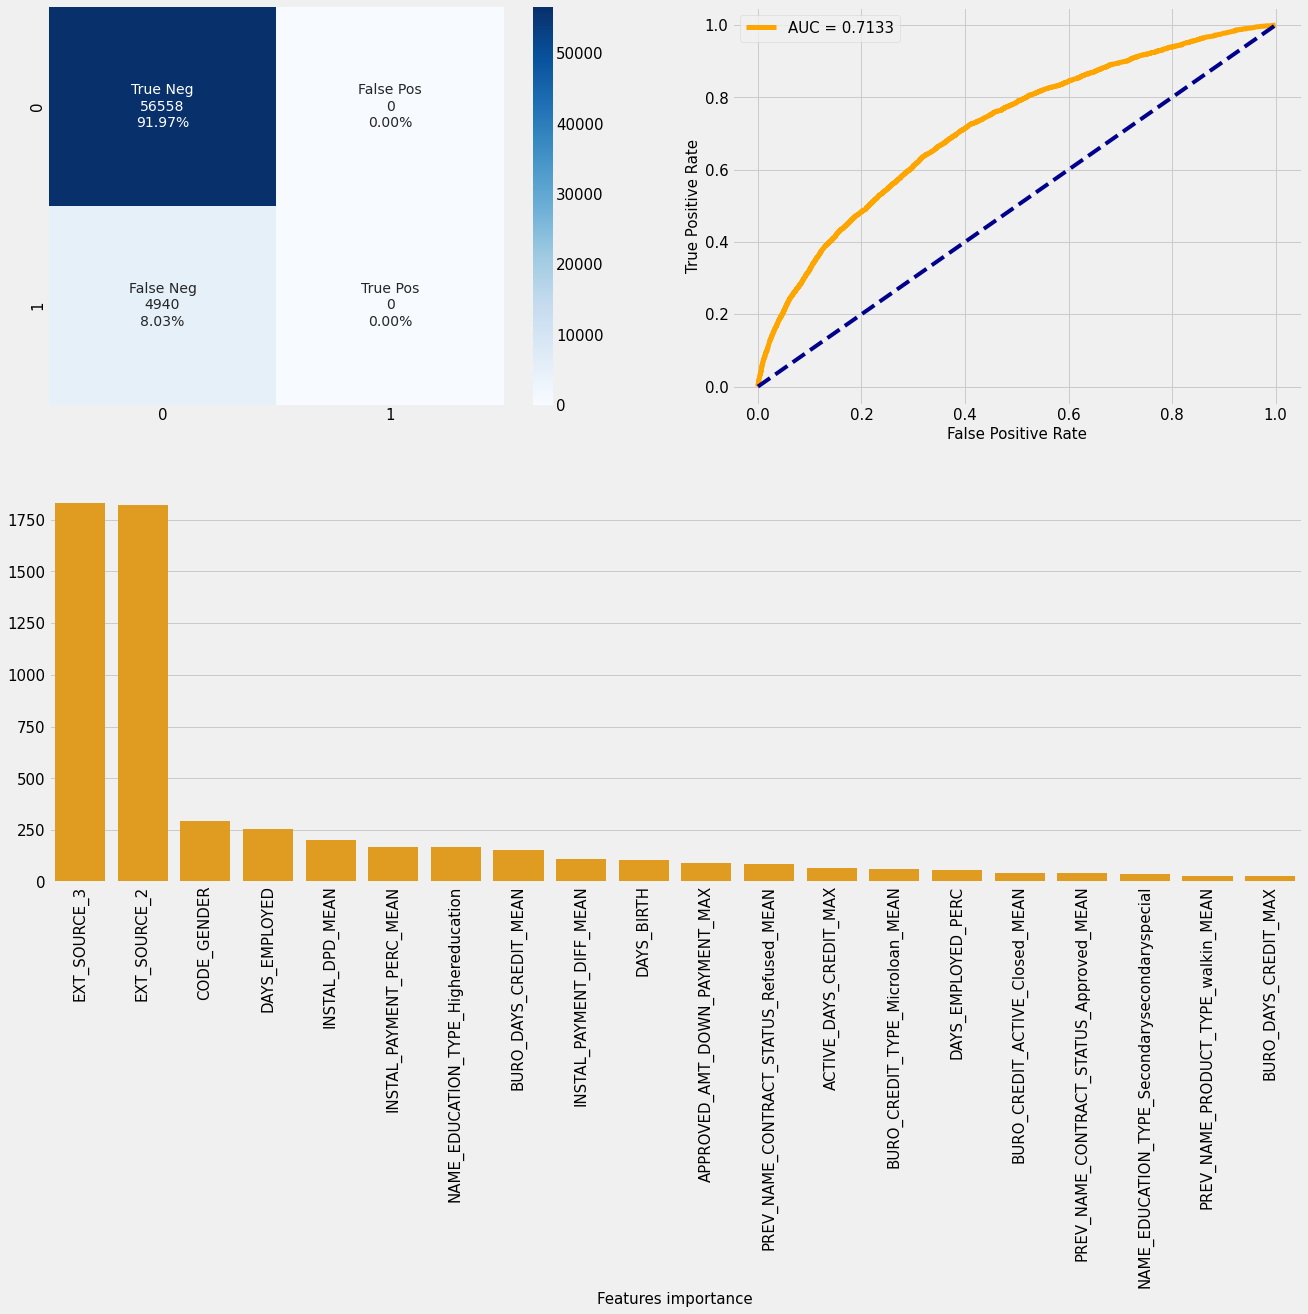

In [379]:
model_summary(lgbm_des_fbeta, y_test, lgbm_des_fbeta.predict(X_test_selected),lgbm_des_fbeta.predict_proba(X_test_selected)[:,1],feature_importances=True)

In [380]:
#FP and FN
cost_false(lgbm_des_fbeta, y_test, X_test_selected)

False Pos: 0.00%
False Neg: 8.03%


(0.0, 0.08032781553871671)

In [381]:
#Check list features importance 
sorted_idx = np.argsort(lgbm_des_fbeta.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_test_selected.columns[index], lgbm_des_fbeta.feature_importances_[index]]) 

['EXT_SOURCE_3', 1830]
['EXT_SOURCE_2', 1819]
['CODE_GENDER', 292]
['DAYS_EMPLOYED', 255]
['INSTAL_DPD_MEAN', 204]
['INSTAL_PAYMENT_PERC_MEAN', 170]
['NAME_EDUCATION_TYPE_Highereducation', 166]
['BURO_DAYS_CREDIT_MEAN', 156]
['INSTAL_PAYMENT_DIFF_MEAN', 108]
['DAYS_BIRTH', 106]
['APPROVED_AMT_DOWN_PAYMENT_MAX', 93]
['PREV_NAME_CONTRACT_STATUS_Refused_MEAN', 86]
['ACTIVE_DAYS_CREDIT_MAX', 69]
['BURO_CREDIT_TYPE_Microloan_MEAN', 61]
['DAYS_EMPLOYED_PERC', 59]
['BURO_CREDIT_ACTIVE_Closed_MEAN', 44]
['PREV_NAME_CONTRACT_STATUS_Approved_MEAN', 43]
['NAME_EDUCATION_TYPE_Secondarysecondaryspecial', 39]
['PREV_NAME_PRODUCT_TYPE_walkin_MEAN', 29]
['BURO_DAYS_CREDIT_MAX', 28]
['NAME_CONTRACT_TYPE_Cashloans', 27]
['REGION_RATING_CLIENT_W_CITY', 25]
['PAYMENT_RATE', 23]
['AMT_ANNUITY', 23]
['DAYS_LAST_PHONE_CHANGE', 22]
['FLAG_DOCUMENT_3', 20]
['PREV_NAME_PORTFOLIO_POS_MEAN', 18]
['INSTAL_AMT_PAYMENT_MIN', 17]
['APPROVED_RATE_DOWN_PAYMENT_MAX', 16]
['POS_MONTHS_BALANCE_SIZE', 14]
['PREV_APP_CREDIT

## lgbm_eq_fbeta

In [382]:
lgbm_eq_fbeta = classifiers["lgbm_eq_fbeta"]

In [383]:
roc_auc = roc_auc_score(y_test, lgbm_eq_fbeta.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.709694


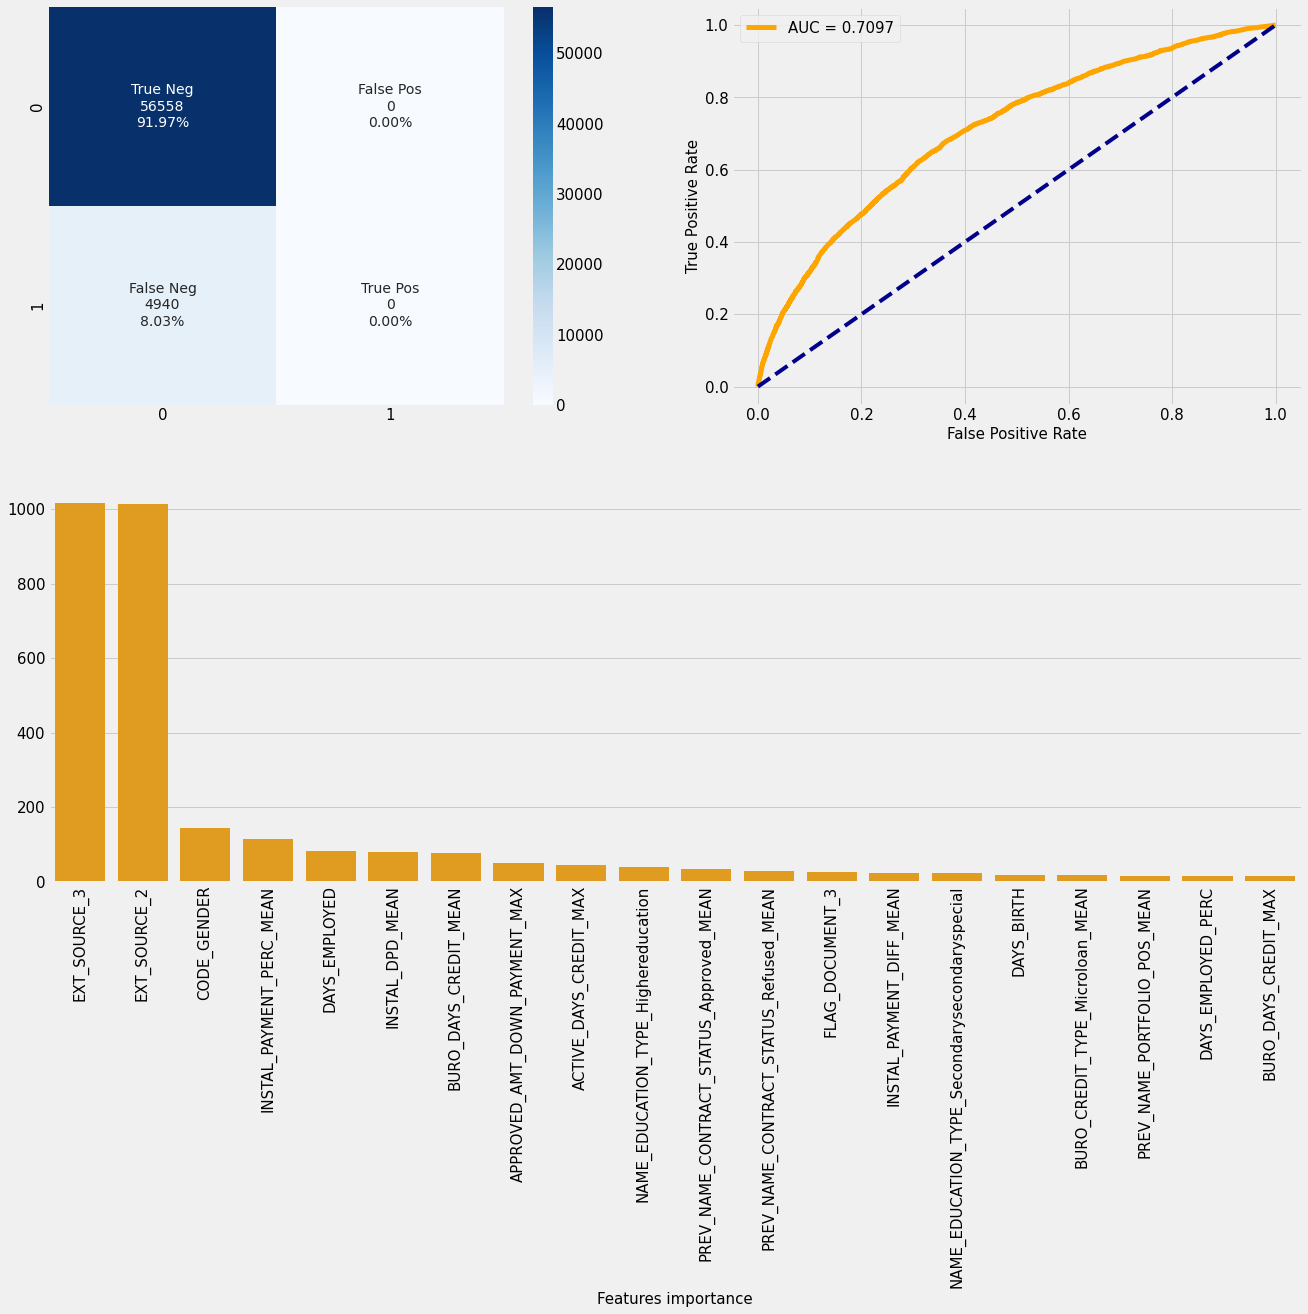

In [384]:
model_summary(lgbm_eq_fbeta, y_test, lgbm_eq_fbeta.predict(X_test_selected), lgbm_eq_fbeta.predict_proba(X_test_selected)[:,1],feature_importances=True)

In [385]:
#FP and FN
cost_false(lgbm_eq_fbeta, y_test, X_test_selected)

False Pos: 0.00%
False Neg: 8.03%


(0.0, 0.08032781553871671)

In [386]:
#Check list features importance 
sorted_idx = np.argsort(lgbm_eq_fbeta.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_test_selected.columns[index], lgbm_eq_fbeta.feature_importances_[index]]) 

['EXT_SOURCE_3', 1016]
['EXT_SOURCE_2', 1014]
['CODE_GENDER', 145]
['INSTAL_PAYMENT_PERC_MEAN', 114]
['DAYS_EMPLOYED', 83]
['INSTAL_DPD_MEAN', 81]
['BURO_DAYS_CREDIT_MEAN', 76]
['APPROVED_AMT_DOWN_PAYMENT_MAX', 51]
['ACTIVE_DAYS_CREDIT_MAX', 46]
['NAME_EDUCATION_TYPE_Highereducation', 40]
['PREV_NAME_CONTRACT_STATUS_Approved_MEAN', 35]
['PREV_NAME_CONTRACT_STATUS_Refused_MEAN', 28]
['FLAG_DOCUMENT_3', 27]
['INSTAL_PAYMENT_DIFF_MEAN', 23]
['NAME_EDUCATION_TYPE_Secondarysecondaryspecial', 23]
['DAYS_BIRTH', 18]
['BURO_CREDIT_TYPE_Microloan_MEAN', 17]
['PREV_NAME_PORTFOLIO_POS_MEAN', 16]
['DAYS_EMPLOYED_PERC', 15]
['BURO_DAYS_CREDIT_MAX', 15]
['PREV_NAME_PRODUCT_TYPE_walkin_MEAN', 14]
['NAME_CONTRACT_TYPE_Cashloans', 13]
['REGION_RATING_CLIENT_W_CITY', 12]
['AMT_ANNUITY', 10]
['BURO_CREDIT_ACTIVE_Active_MEAN', 10]
['DAYS_LAST_PHONE_CHANGE', 10]
['POS_MONTHS_BALANCE_SIZE', 6]
['PREV_CODE_REJECT_REASON_XAP_MEAN', 5]
['APPROVED_DAYS_DECISION_MIN', 5]
['BURO_CREDIT_ACTIVE_Closed_MEAN', 4]
['P

## lgbm_des_auc

In [387]:
lgbm_des_auc = classifiers["lgbm_des_auc"]

In [388]:
roc_auc = roc_auc_score(y_test, lgbm_des_auc.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.779338


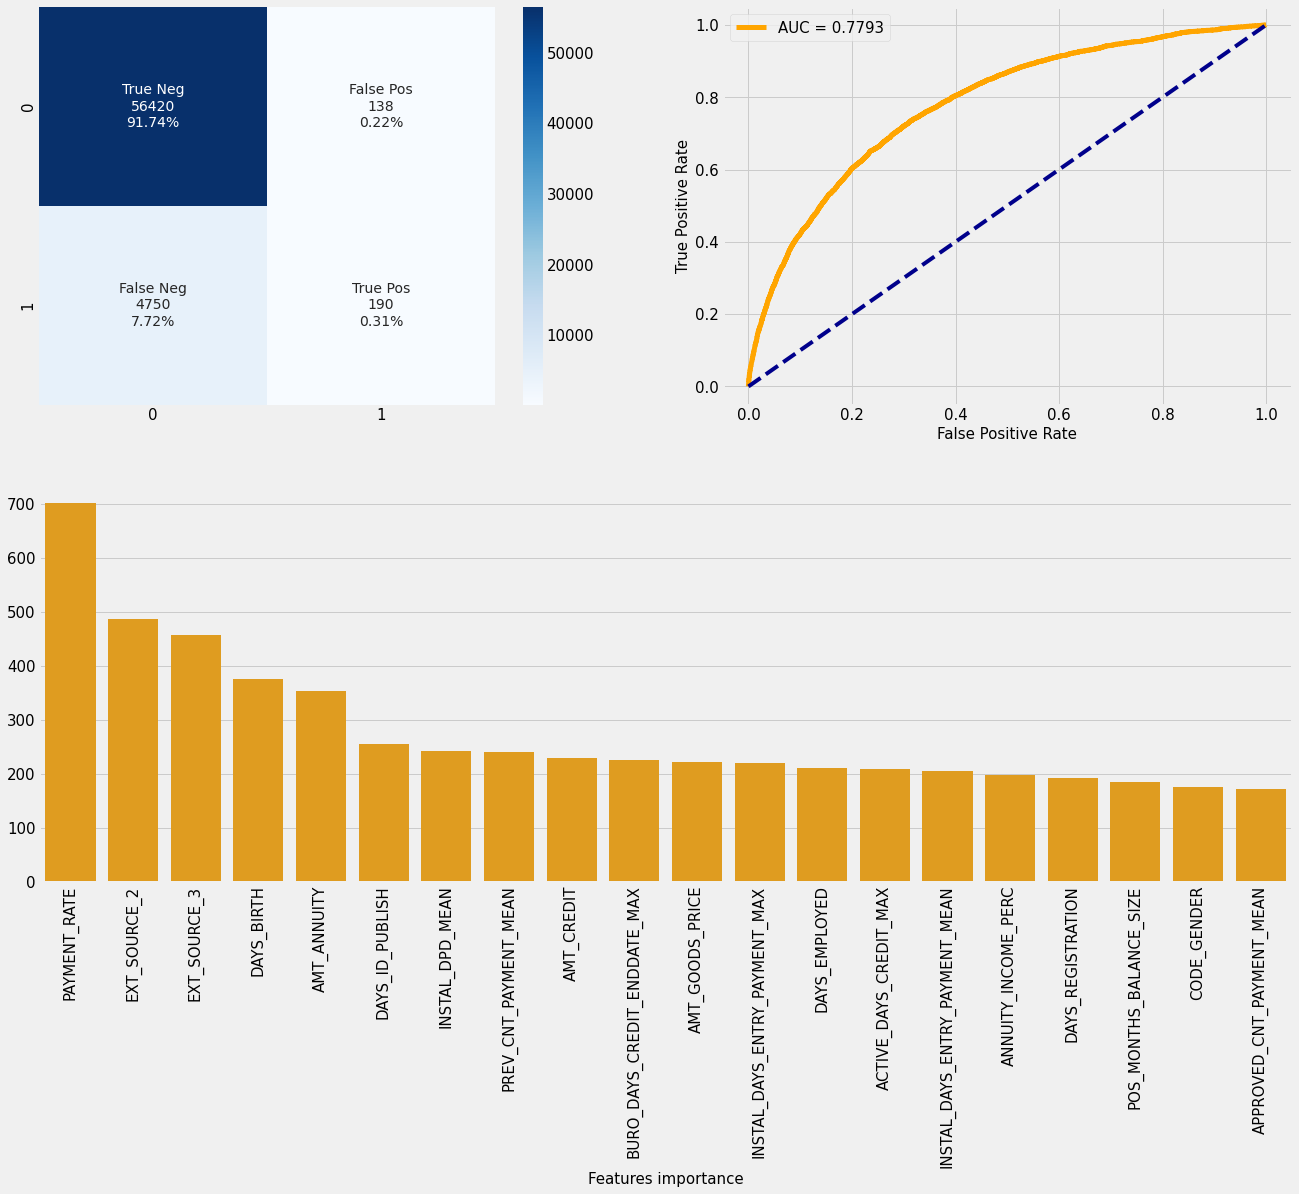

In [389]:
model_summary(lgbm_des_auc, y_test, lgbm_des_auc.predict(X_test_selected), lgbm_des_auc.predict_proba(X_test_selected)[:,1],feature_importances=True)

In [390]:
#FP and FN
cost_false(lgbm_des_auc, y_test, X_test_selected)

False Pos: 0.22%
False Neg: 7.72%


(0.0022439754138345964, 0.07723828417184299)

In [391]:
#Check list features importance 
sorted_idx = np.argsort(lgbm_des_auc.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_test_selected.columns[index], lgbm_des_auc.feature_importances_[index]]) 

['PAYMENT_RATE', 702]
['EXT_SOURCE_2', 487]
['EXT_SOURCE_3', 458]
['DAYS_BIRTH', 376]
['AMT_ANNUITY', 354]
['DAYS_ID_PUBLISH', 255]
['INSTAL_DPD_MEAN', 242]
['PREV_CNT_PAYMENT_MEAN', 241]
['AMT_CREDIT', 230]
['BURO_DAYS_CREDIT_ENDDATE_MAX', 225]
['AMT_GOODS_PRICE', 222]
['INSTAL_DAYS_ENTRY_PAYMENT_MAX', 220]
['DAYS_EMPLOYED', 211]
['ACTIVE_DAYS_CREDIT_MAX', 208]
['INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 206]
['ANNUITY_INCOME_PERC', 198]
['DAYS_REGISTRATION', 192]
['POS_MONTHS_BALANCE_SIZE', 184]
['CODE_GENDER', 175]
['APPROVED_CNT_PAYMENT_MEAN', 171]
['INSTAL_AMT_PAYMENT_SUM', 168]
['CLOSED_DAYS_CREDIT_MAX', 166]
['INSTAL_AMT_PAYMENT_MIN', 165]
['DAYS_EMPLOYED_PERC', 158]
['PREV_APP_CREDIT_PERC_MIN', 150]
['APPROVED_DAYS_DECISION_MAX', 142]
['BURO_AMT_CREDIT_SUM_DEBT_MEAN', 137]
['APPROVED_AMT_ANNUITY_MEAN', 134]
['DAYS_LAST_PHONE_CHANGE', 134]
['INSTAL_DAYS_ENTRY_PAYMENT_SUM', 131]
['REGION_POPULATION_RELATIVE', 130]
['INSTAL_DBD_MAX', 122]
['INCOME_CREDIT_PERC', 121]
['ACTIVE_AMT_CREDIT_SUM

## lgbm_eq_auc

In [392]:
lgbm_eq_auc = classifiers["lgbm_eq_auc"]

In [393]:
roc_auc = roc_auc_score(y_test, lgbm_eq_auc.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.780193


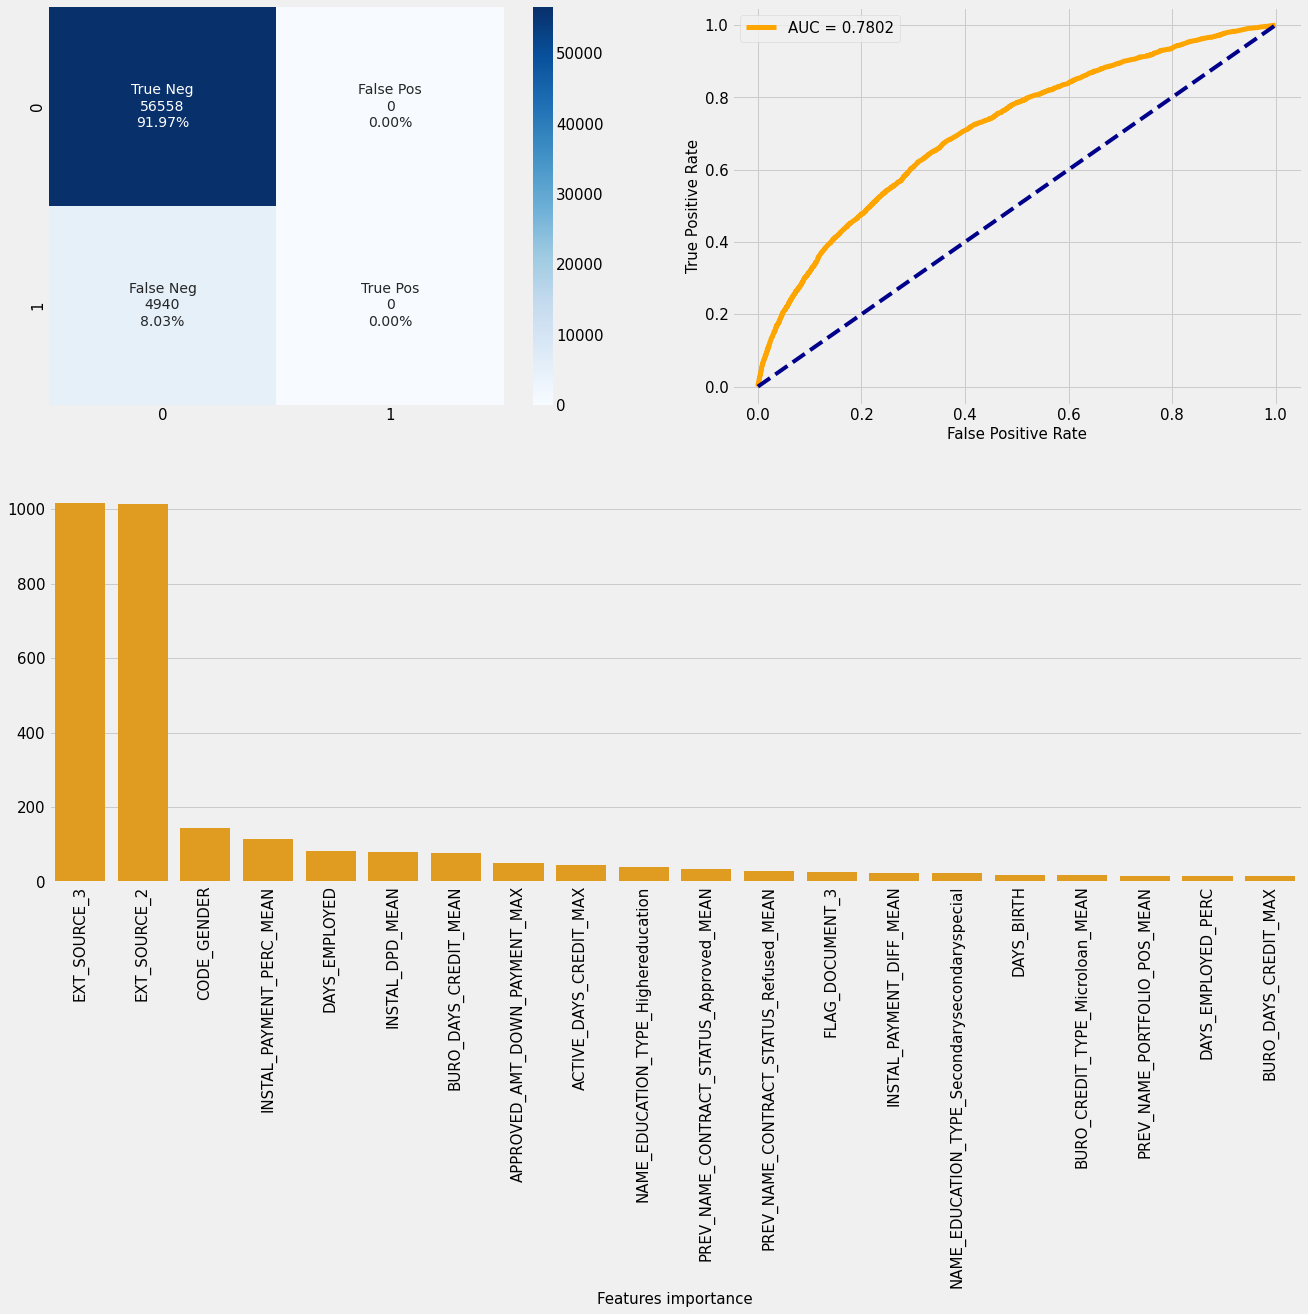

In [394]:
model_summary(lgbm_eq_fbeta, y_test, lgbm_eq_fbeta.predict(X_test_selected), lgbm_eq_fbeta.predict_proba(X_test_selected)[:,1],feature_importances=True)

In [395]:
#FP and FN
cost_false(classifiers["lgbm_eq_fbeta"], y_test, X_test_selected)

False Pos: 0.00%
False Neg: 8.03%


(0.0, 0.08032781553871671)

In [396]:
#Check list features importance 
sorted_idx = np.argsort(classifiers["lgbm_eq_fbeta"].feature_importances_)[::-1]
for index in sorted_idx:
    print([X_test_selected.columns[index], classifiers["lgbm_eq_fbeta"].feature_importances_[index]]) 

['EXT_SOURCE_3', 1016]
['EXT_SOURCE_2', 1014]
['CODE_GENDER', 145]
['INSTAL_PAYMENT_PERC_MEAN', 114]
['DAYS_EMPLOYED', 83]
['INSTAL_DPD_MEAN', 81]
['BURO_DAYS_CREDIT_MEAN', 76]
['APPROVED_AMT_DOWN_PAYMENT_MAX', 51]
['ACTIVE_DAYS_CREDIT_MAX', 46]
['NAME_EDUCATION_TYPE_Highereducation', 40]
['PREV_NAME_CONTRACT_STATUS_Approved_MEAN', 35]
['PREV_NAME_CONTRACT_STATUS_Refused_MEAN', 28]
['FLAG_DOCUMENT_3', 27]
['INSTAL_PAYMENT_DIFF_MEAN', 23]
['NAME_EDUCATION_TYPE_Secondarysecondaryspecial', 23]
['DAYS_BIRTH', 18]
['BURO_CREDIT_TYPE_Microloan_MEAN', 17]
['PREV_NAME_PORTFOLIO_POS_MEAN', 16]
['DAYS_EMPLOYED_PERC', 15]
['BURO_DAYS_CREDIT_MAX', 15]
['PREV_NAME_PRODUCT_TYPE_walkin_MEAN', 14]
['NAME_CONTRACT_TYPE_Cashloans', 13]
['REGION_RATING_CLIENT_W_CITY', 12]
['AMT_ANNUITY', 10]
['BURO_CREDIT_ACTIVE_Active_MEAN', 10]
['DAYS_LAST_PHONE_CHANGE', 10]
['POS_MONTHS_BALANCE_SIZE', 6]
['PREV_CODE_REJECT_REASON_XAP_MEAN', 5]
['APPROVED_DAYS_DECISION_MIN', 5]
['BURO_CREDIT_ACTIVE_Closed_MEAN', 4]
['P

# Évalutation des modèles sur les donnée équilibrer

In [420]:
%%time

names = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
f_beta =[]
time_ = []

for name, model in classifiers.items():
    start = time.time()
    results = train_models_v2(model, X_train_rus_selected, X_test_selected, y_train_rus, y_test)
   
    names.append(name)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    f_beta.append(results['F_beta'])
    time_.append(time.time()-start)

#Initialise data of lists
models_final_eq = pd.DataFrame(data=[names, auc, accuracy, precision, recall, f1, f_beta, time_]).T
models_final_eq.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1','F_beta', 'Time']
models_final_eq.sort_values('F_beta', ascending=False, inplace=True)

CPU times: total: 4min 6s
Wall time: 1min 12s


## lgbm_des_fbeta

In [398]:
lgbm_des_fbeta = classifiers["lgbm_des_fbeta"]

In [399]:
roc_auc = roc_auc_score(y_test, lgbm_des_fbeta.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.713351


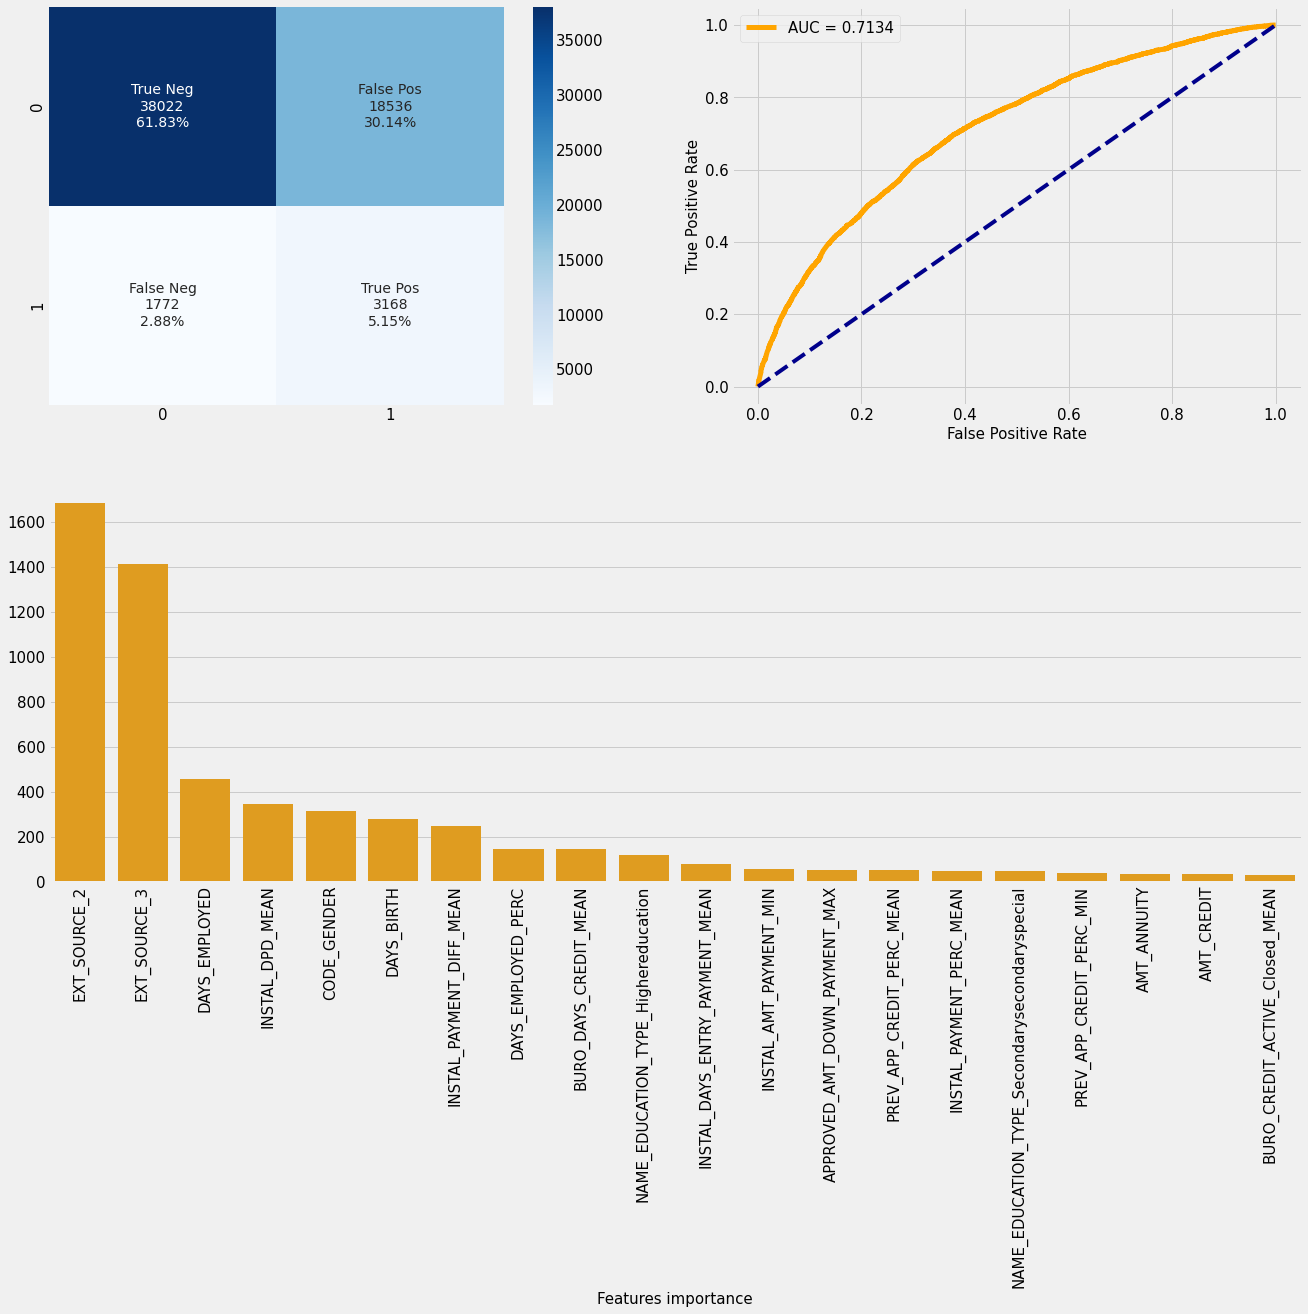

In [400]:
model_summary(lgbm_des_fbeta, y_test, lgbm_des_fbeta.predict(X_test_selected),lgbm_des_fbeta.predict_proba(X_test_selected)[:,1],feature_importances=True)

In [401]:
#FP and FN
cost_false(lgbm_des_fbeta, y_test, X_test_selected)

False Pos: 30.14%
False Neg: 2.88%


(0.30140817587563823, 0.028813945168948585)

In [402]:
#Check list features importance 
sorted_idx = np.argsort(lgbm_des_fbeta.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_test_selected.columns[index], lgbm_des_fbeta.feature_importances_[index]]) 

['EXT_SOURCE_2', 1684]
['EXT_SOURCE_3', 1414]
['DAYS_EMPLOYED', 456]
['INSTAL_DPD_MEAN', 345]
['CODE_GENDER', 314]
['DAYS_BIRTH', 281]
['INSTAL_PAYMENT_DIFF_MEAN', 248]
['DAYS_EMPLOYED_PERC', 147]
['BURO_DAYS_CREDIT_MEAN', 146]
['NAME_EDUCATION_TYPE_Highereducation', 118]
['INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 81]
['INSTAL_AMT_PAYMENT_MIN', 58]
['APPROVED_AMT_DOWN_PAYMENT_MAX', 54]
['PREV_APP_CREDIT_PERC_MEAN', 53]
['INSTAL_PAYMENT_PERC_MEAN', 50]
['NAME_EDUCATION_TYPE_Secondarysecondaryspecial', 50]
['PREV_APP_CREDIT_PERC_MIN', 41]
['AMT_ANNUITY', 35]
['AMT_CREDIT', 34]
['BURO_CREDIT_ACTIVE_Closed_MEAN', 32]
['BURO_DAYS_CREDIT_ENDDATE_MEAN', 31]
['INSTAL_DPD_MAX', 30]
['PREV_NAME_CONTRACT_STATUS_Refused_MEAN', 28]
['INSTAL_PAYMENT_DIFF_SUM', 27]
['BURO_DAYS_CREDIT_UPDATE_MEAN', 23]
['APPROVED_DAYS_DECISION_MIN', 22]
['PREV_CODE_REJECT_REASON_XAP_MEAN', 20]
['DAYS_LAST_PHONE_CHANGE', 18]
['PREV_AMT_CREDIT_MAX', 15]
['PREV_CNT_PAYMENT_MEAN', 11]
['PREV_AMT_DOWN_PAYMENT_MAX', 11]
['PREV_APP_

## lgbm_eq_fbeta

In [403]:
lgbm_eq_fbeta = classifiers["lgbm_eq_fbeta"]

In [404]:
roc_auc = roc_auc_score(y_test, lgbm_eq_fbeta.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.709965


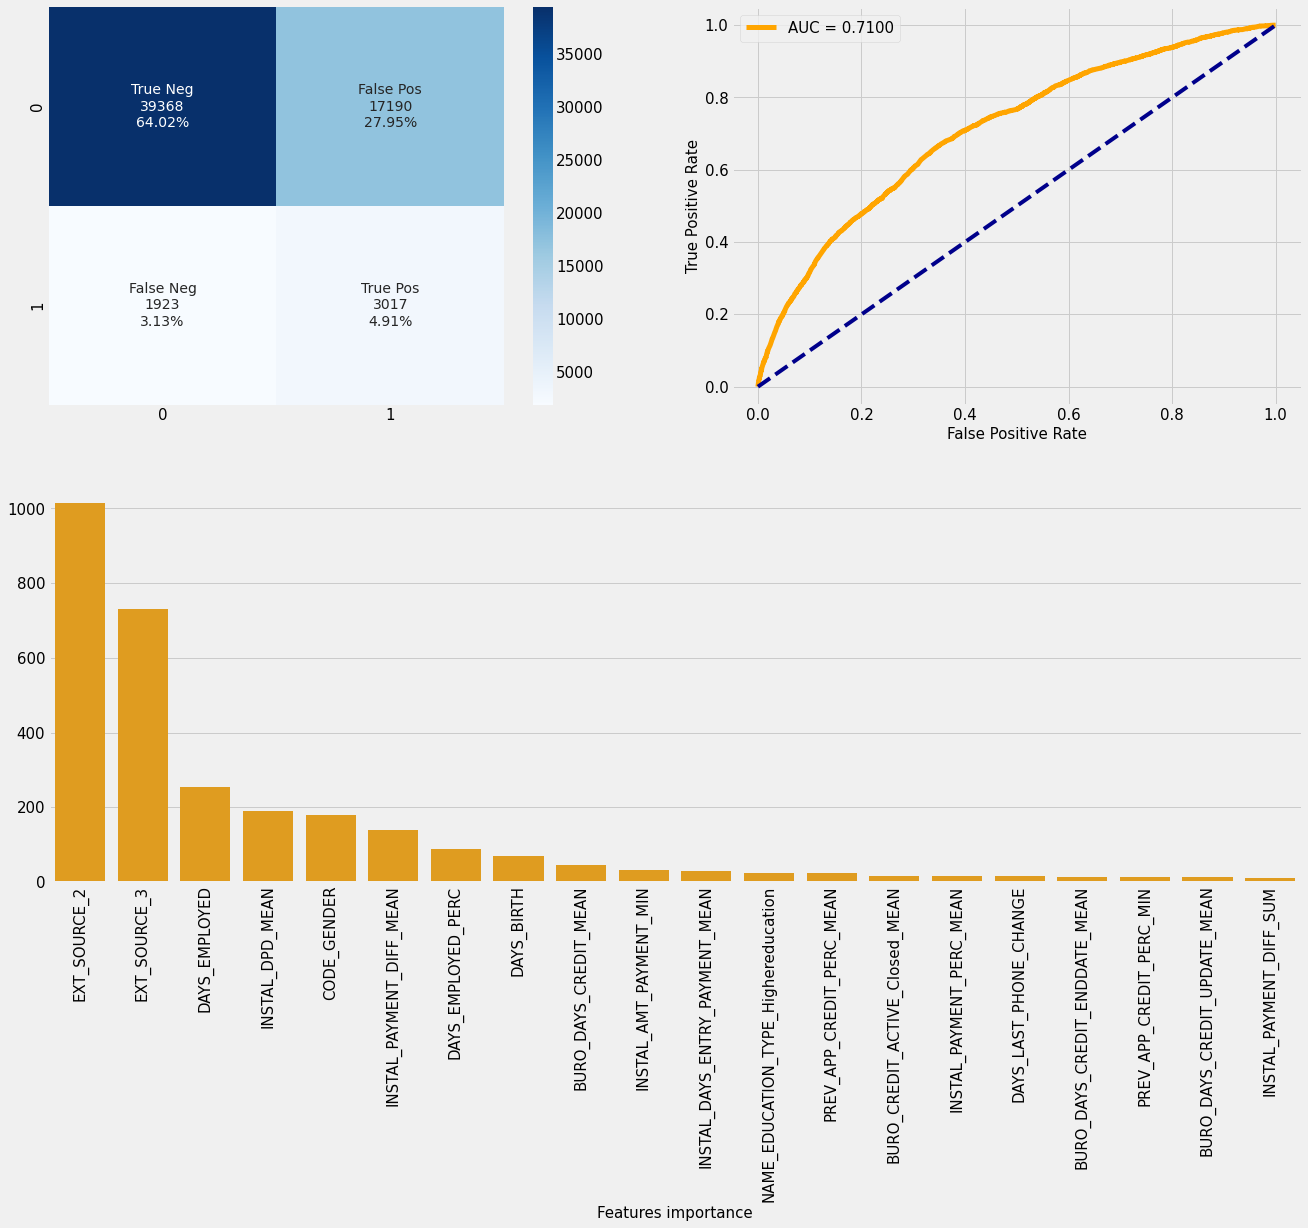

In [405]:
model_summary(lgbm_eq_fbeta, y_test, lgbm_eq_fbeta.predict(X_test_selected), lgbm_eq_fbeta.predict_proba(X_test_selected)[:,1],feature_importances=True)

In [406]:
#FP and FN
cost_false(lgbm_eq_fbeta, y_test, X_test_selected)

False Pos: 27.95%
False Neg: 3.13%


(0.2795212852450486, 0.03126930957104296)

In [407]:
#Check list features importance 
sorted_idx = np.argsort(lgbm_eq_fbeta.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_test_selected.columns[index], lgbm_eq_fbeta.feature_importances_[index]]) 

['EXT_SOURCE_2', 1014]
['EXT_SOURCE_3', 732]
['DAYS_EMPLOYED', 254]
['INSTAL_DPD_MEAN', 190]
['CODE_GENDER', 180]
['INSTAL_PAYMENT_DIFF_MEAN', 139]
['DAYS_EMPLOYED_PERC', 89]
['DAYS_BIRTH', 70]
['BURO_DAYS_CREDIT_MEAN', 46]
['INSTAL_AMT_PAYMENT_MIN', 33]
['INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 29]
['NAME_EDUCATION_TYPE_Highereducation', 24]
['PREV_APP_CREDIT_PERC_MEAN', 23]
['BURO_CREDIT_ACTIVE_Closed_MEAN', 17]
['INSTAL_PAYMENT_PERC_MEAN', 17]
['DAYS_LAST_PHONE_CHANGE', 15]
['BURO_DAYS_CREDIT_ENDDATE_MEAN', 14]
['PREV_APP_CREDIT_PERC_MIN', 13]
['BURO_DAYS_CREDIT_UPDATE_MEAN', 13]
['INSTAL_PAYMENT_DIFF_SUM', 11]
['APPROVED_AMT_DOWN_PAYMENT_MAX', 10]
['APPROVED_HOUR_APPR_PROCESS_START_MAX', 10]
['PREV_NAME_CONTRACT_STATUS_Refused_MEAN', 10]
['NAME_EDUCATION_TYPE_Secondarysecondaryspecial', 9]
['PREV_AMT_CREDIT_MAX', 4]
['PREV_NAME_GOODS_CATEGORY_Furniture_MEAN', 4]
['BURO_CREDIT_ACTIVE_Active_MEAN', 4]
['INSTAL_DAYS_ENTRY_PAYMENT_SUM', 3]
['PREV_DAYS_DECISION_MEAN', 3]
['PAYMENT_RATE', 3]
['

## lgbm_des_auc

In [408]:
lgbm_des_auc = classifiers["lgbm_des_auc"]

In [409]:
roc_auc = roc_auc_score(y_test, lgbm_des_auc.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.775320


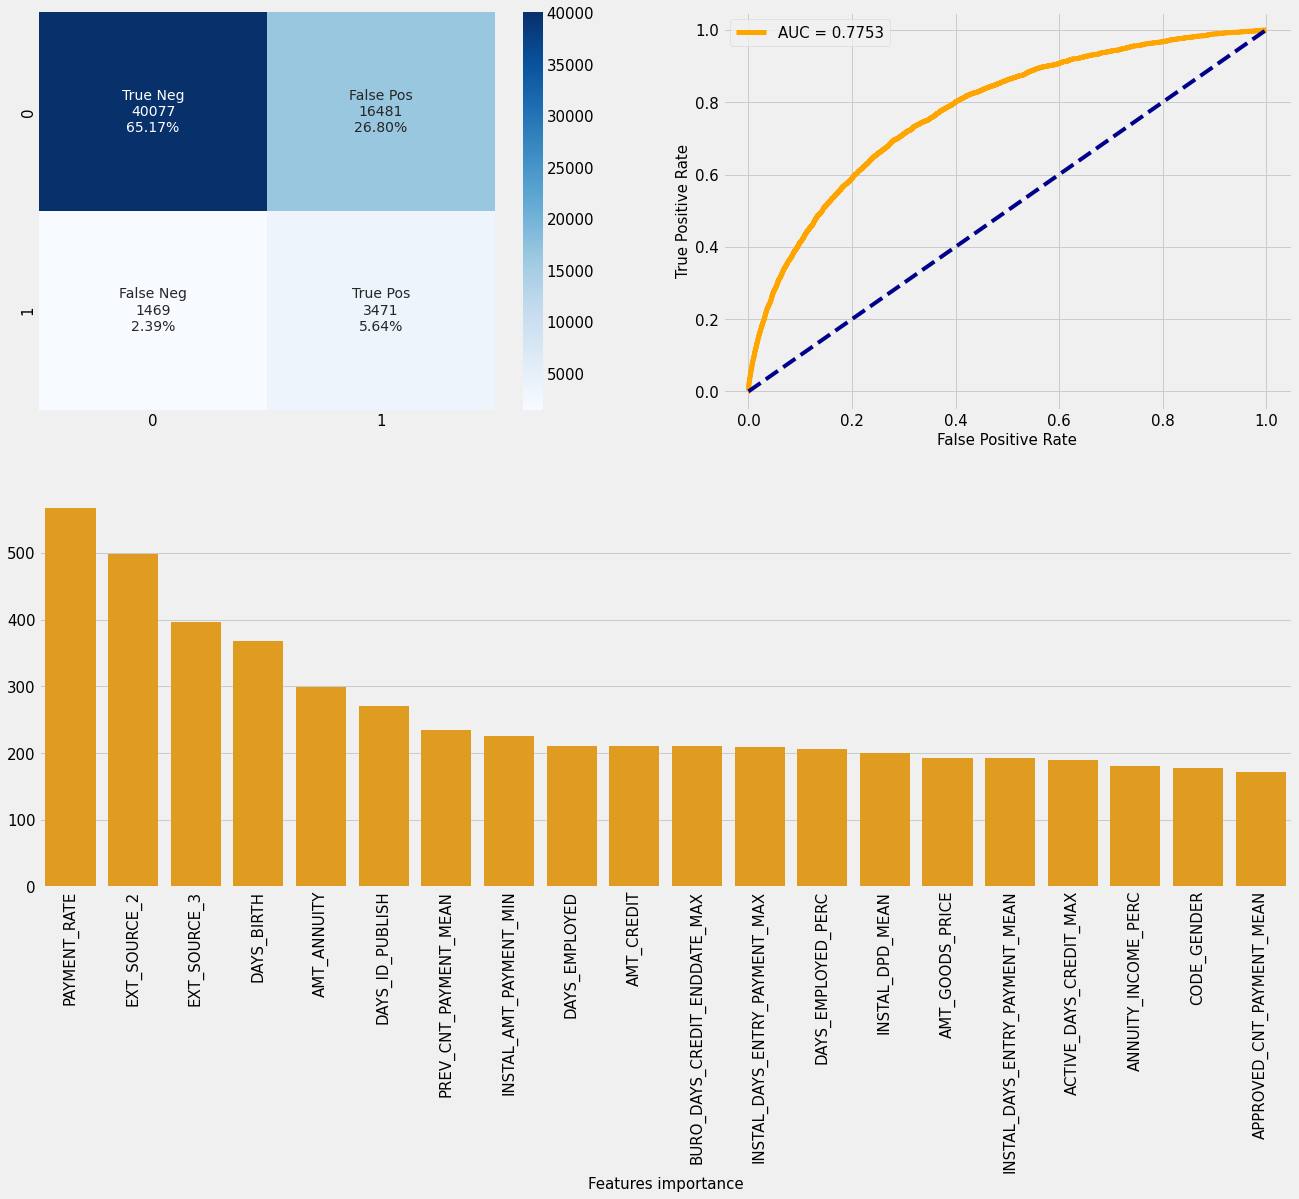

In [410]:
model_summary(lgbm_des_auc, y_test, lgbm_des_auc.predict(X_test_selected), lgbm_des_auc.predict_proba(X_test_selected)[:,1],feature_importances=True)

In [411]:
#FP and FN
cost_false(lgbm_des_auc, y_test, X_test_selected)

False Pos: 26.80%
False Neg: 2.39%


(0.2679924550391883, 0.02388695567335523)

In [412]:
#Check list features importance 
sorted_idx = np.argsort(lgbm_des_auc.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_test_selected.columns[index], lgbm_des_auc.feature_importances_[index]]) 

['PAYMENT_RATE', 567]
['EXT_SOURCE_2', 498]
['EXT_SOURCE_3', 396]
['DAYS_BIRTH', 368]
['AMT_ANNUITY', 299]
['DAYS_ID_PUBLISH', 271]
['PREV_CNT_PAYMENT_MEAN', 234]
['INSTAL_AMT_PAYMENT_MIN', 226]
['DAYS_EMPLOYED', 211]
['AMT_CREDIT', 211]
['BURO_DAYS_CREDIT_ENDDATE_MAX', 210]
['INSTAL_DAYS_ENTRY_PAYMENT_MAX', 209]
['DAYS_EMPLOYED_PERC', 206]
['INSTAL_DPD_MEAN', 200]
['AMT_GOODS_PRICE', 192]
['INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 192]
['ACTIVE_DAYS_CREDIT_MAX', 189]
['ANNUITY_INCOME_PERC', 181]
['CODE_GENDER', 177]
['APPROVED_CNT_PAYMENT_MEAN', 171]
['INCOME_CREDIT_PERC', 167]
['DAYS_REGISTRATION', 167]
['DAYS_LAST_PHONE_CHANGE', 161]
['INSTAL_DBD_SUM', 159]
['ACTIVE_DAYS_CREDIT_UPDATE_MEAN', 152]
['POS_MONTHS_BALANCE_SIZE', 150]
['INSTAL_DAYS_ENTRY_PAYMENT_SUM', 143]
['APPROVED_DAYS_DECISION_MAX', 142]
['REGION_POPULATION_RELATIVE', 135]
['PREV_APP_CREDIT_PERC_MIN', 133]
['INSTAL_AMT_PAYMENT_SUM', 133]
['APPROVED_AMT_ANNUITY_MEAN', 133]
['INSTAL_AMT_PAYMENT_MEAN', 132]
['ACTIVE_AMT_CREDIT_S

## lgbm_eq_auc

In [413]:
lgbm_eq_auc = classifiers["lgbm_eq_auc"]

In [414]:
roc_auc = roc_auc_score(y_test, lgbm_eq_auc.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.775727


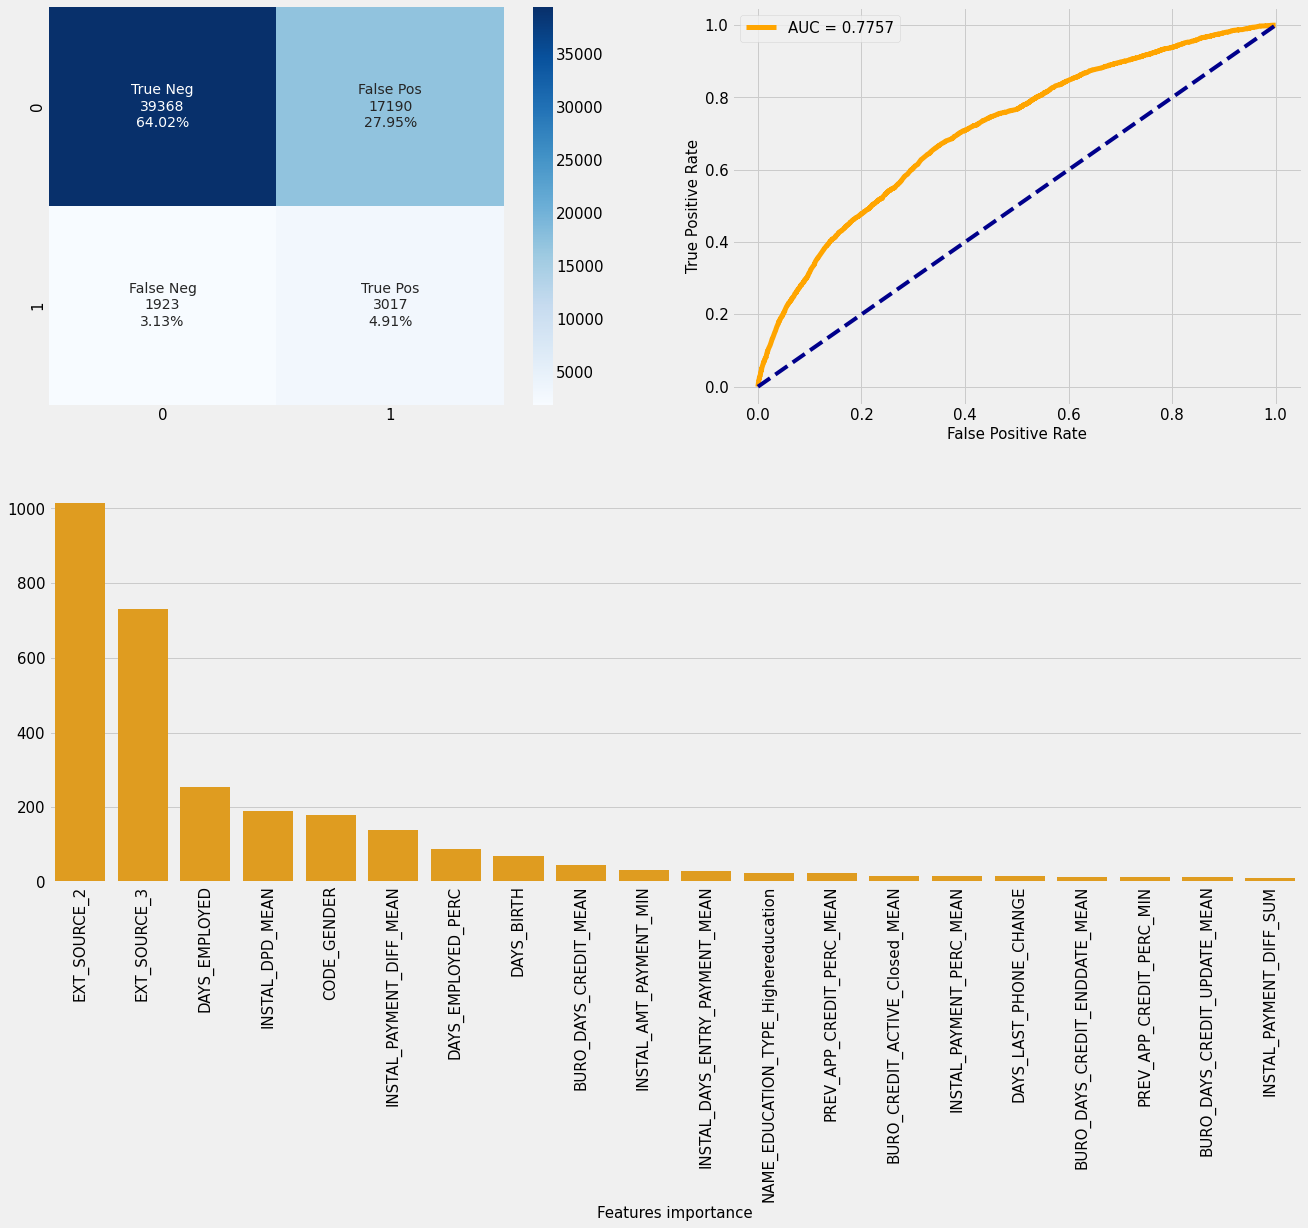

In [415]:
model_summary(lgbm_eq_fbeta, y_test, lgbm_eq_fbeta.predict(X_test_selected), lgbm_eq_fbeta.predict_proba(X_test_selected)[:,1],feature_importances=True)

In [416]:
#FP and FN
cost_false(classifiers["lgbm_eq_fbeta"], y_test, X_test_selected)

False Pos: 27.95%
False Neg: 3.13%


(0.2795212852450486, 0.03126930957104296)

In [417]:
#Check list features importance 
sorted_idx = np.argsort(classifiers["lgbm_eq_fbeta"].feature_importances_)[::-1]
for index in sorted_idx:
    print([X_test_selected.columns[index], classifiers["lgbm_eq_fbeta"].feature_importances_[index]]) 

['EXT_SOURCE_2', 1014]
['EXT_SOURCE_3', 732]
['DAYS_EMPLOYED', 254]
['INSTAL_DPD_MEAN', 190]
['CODE_GENDER', 180]
['INSTAL_PAYMENT_DIFF_MEAN', 139]
['DAYS_EMPLOYED_PERC', 89]
['DAYS_BIRTH', 70]
['BURO_DAYS_CREDIT_MEAN', 46]
['INSTAL_AMT_PAYMENT_MIN', 33]
['INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 29]
['NAME_EDUCATION_TYPE_Highereducation', 24]
['PREV_APP_CREDIT_PERC_MEAN', 23]
['BURO_CREDIT_ACTIVE_Closed_MEAN', 17]
['INSTAL_PAYMENT_PERC_MEAN', 17]
['DAYS_LAST_PHONE_CHANGE', 15]
['BURO_DAYS_CREDIT_ENDDATE_MEAN', 14]
['PREV_APP_CREDIT_PERC_MIN', 13]
['BURO_DAYS_CREDIT_UPDATE_MEAN', 13]
['INSTAL_PAYMENT_DIFF_SUM', 11]
['APPROVED_AMT_DOWN_PAYMENT_MAX', 10]
['APPROVED_HOUR_APPR_PROCESS_START_MAX', 10]
['PREV_NAME_CONTRACT_STATUS_Refused_MEAN', 10]
['NAME_EDUCATION_TYPE_Secondarysecondaryspecial', 9]
['PREV_AMT_CREDIT_MAX', 4]
['PREV_NAME_GOODS_CATEGORY_Furniture_MEAN', 4]
['BURO_CREDIT_ACTIVE_Active_MEAN', 4]
['INSTAL_DAYS_ENTRY_PAYMENT_SUM', 3]
['PREV_DAYS_DECISION_MEAN', 3]
['PAYMENT_RATE', 3]
['

# Conclusion

In [422]:
models_final_des

,Model,AUC,Accuracy,Precision,Recall,F1,F_beta,Time
2,lgbm_des_auc,0.779338,0.920518,0.579268,0.038462,0.072134,0.991944,33.622221
3,lgbm_eq_auc,0.780193,0.920274,0.55836,0.03583,0.067339,0.992143,34.394476
0,lgbm_des_fbeta,0.713276,0.919672,0.0,0.0,0.0,0.994888,23.015007
1,lgbm_eq_fbeta,0.709694,0.919672,0.0,0.0,0.0,0.994888,17.378506


In [423]:
models_final_eq

,Model,AUC,Accuracy,Precision,Recall,F1,F_beta,Time
1,lgbm_eq_fbeta,0.709965,0.689209,0.149305,0.610729,0.239949,0.930232,11.97305
0,lgbm_des_fbeta,0.713351,0.669778,0.145964,0.641296,0.237802,0.924932,15.061941
3,lgbm_eq_auc,0.77572,0.707194,0.173145,0.700607,0.277669,0.922894,22.853313
2,lgbm_des_auc,0.775322,0.708121,0.173968,0.702632,0.278885,0.92279,22.898553


L'optimisation des paramètres c'est faites sur les données équilibrées, et déséquilibrées mais également l'évaluation de leurs performances c'est faite avec deux métriques AUC et une fonction coût, f_beta_score. En fixant le beta = 4 nous avons maximisé le recall ce qui  équivaut à  minimiser le nombre de  FN.
Nous avions au final 4 modèles :
- lgbm_des_fbeta:  optimiser sur les données déséquilibrées et évaluer avec le f_beta_score
- lgbm_eq_fbeta:  optimiser sur les données équilibrées et évaluer avec le f_beta_score
- lgbm_des_auc:  optimiser sur les données déséquilibrées et évaluer avec l'AUC
- lgbm_eq_auc: optimiser sur les données équilibrées et évaluer avec l'AUC

Les modèles étant optimisés, nous les avons comparés sur les données déséquilibrées et équilibrées :

1. Sur les données déséquilibrées, malgré le fait que 2 d'entre soit optimisé sur celle-ci, le pourcentage de FN reste élevé, 8% et FP de 0%. Le plus performant avec la métrique AUC était le lgbm_eq_auc (0.78). Mais tous les modèles ont un f_beta_score élevé de 0.99.

2. Maintenant sur les données rééquilibrées, nous pouvons constater que pour des AUC équivalente que précédemment (0.77), nous avons un taux de FN bien inférieur, entre 2 et 3%. Ce qui signifie que le rééquilibrage des données est nécessaire pour limiter les pertes financières de l'entreprise. Nous constatons également que le f_beta_score est inférieur que précédemment, puisque le taux de FP a augmenté, entre 26 et 30%. Ce qui n'est pas négligeable. Les f_beta_score à un e varaition très faible, entre 0.922 et 0.93. On peut dire qu'ils sont tous équivalents. 

Le modèle lgbm_eq_auc à l'AUC la plus faible (0.709) mais avec un f_beta_score de 0.93 il est celui qui limite au mieux les FP. 

En revanche lgbm_eq_auc à une AUC la plus haute (0.77572) et un f_beta_score 0.922894 (3e).

Le modèle lgbm_des_auc à les taux de FN et FP les plus bas (FN: 2.39% et FP: 26.8%) avec un f_beta_score le plus bas (0.922) et l'AUC la deuxième la plus élevée (0.7753).

Au final nous allons choisir le modèle lgbm_des_auc qui nous semble être le bon compromis entre les 2 métriques AUC et f_beta_score mais aussi en terme de taux de FN et FP. Le f_beta_score à permis d'améliorer que très légèrement notre choix, mais son défaut majeur est qu'il manque de sensibilité car on se retrouve avec des variations trop faibles.

In [434]:
#enregistrment du modèle
pickle.dump(lgbm_des_auc, open("LGBMClassifier.pkl", "wb"))